In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.model_selection import StratifiedKFold, cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


# Dataset Exploration

/tmp/ipython-input-4006069718.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="NSP", data=df, palette="Set2")


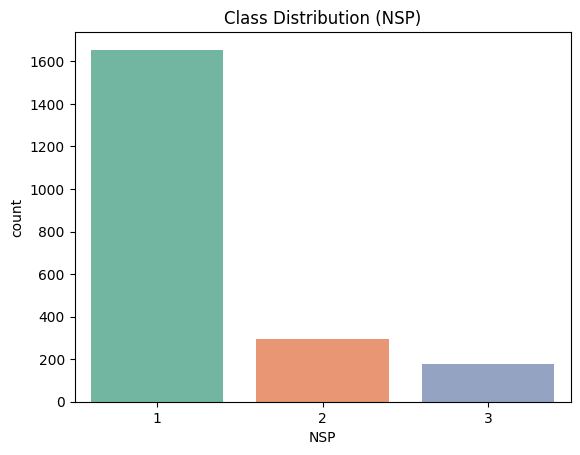

In [2]:
# Load dataset
df = pd.read_excel("data_cardio.xlsx", sheet_name="Raw Data")  # adjust sheet name if needed

sns.countplot(x="NSP", data=df, palette="Set2")
plt.title("Class Distribution (NSP)")
plt.show()



- Shows how many cases are Normal (1), Suspect (2), Pathological (3).

- Class 1 dominates, classes 2 and 3 are underrepresented.


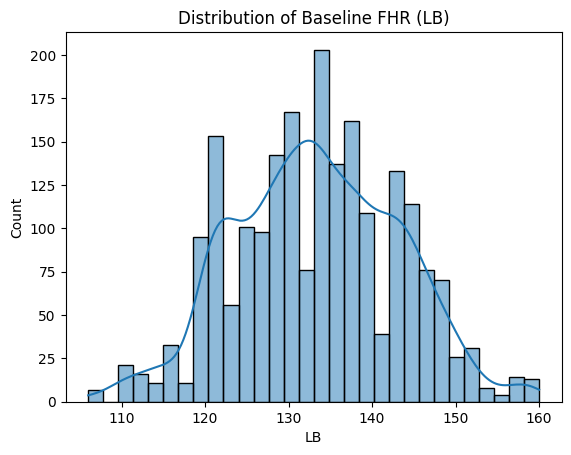

In [3]:
sns.histplot(df["LB"], kde=True, bins=30)
plt.title("Distribution of Baseline FHR (LB)")
plt.show()

Shows how baseline fetal heart rate is spread across patients.


/tmp/ipython-input-3088966319.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="LB", data=df, palette="Set2")


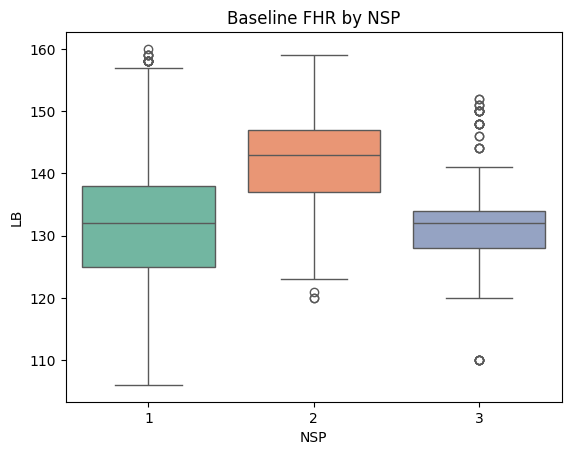

In [4]:
sns.boxplot(x="NSP", y="LB", data=df, palette="Set2")
plt.title("Baseline FHR by NSP")
plt.show()

Compares LB across normal/suspect/pathological groups.

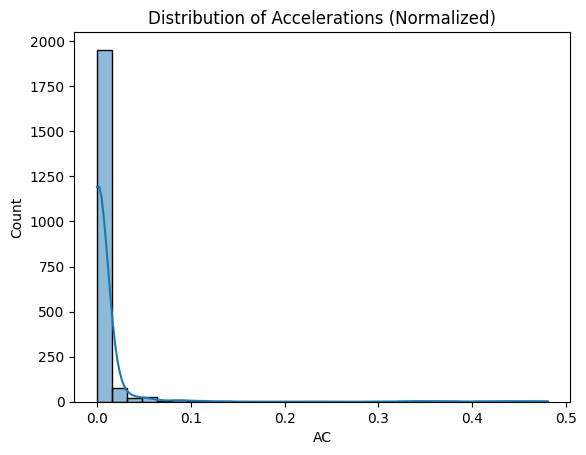

/tmp/ipython-input-1586030682.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="AC", data=df, palette="Set2")


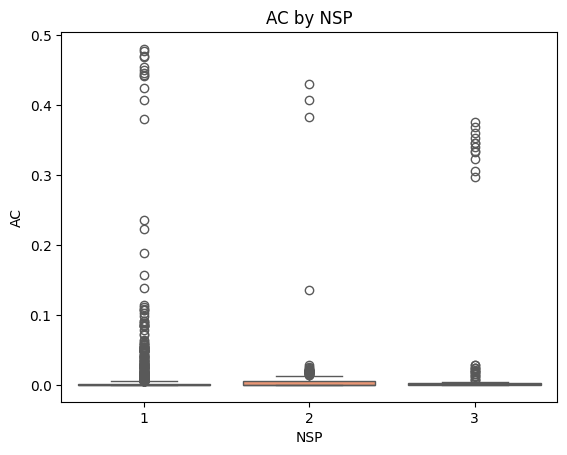

In [5]:
sns.histplot(df["AC"], kde=True, bins=30)
plt.title("Distribution of Accelerations (Normalized)")
plt.show()

sns.boxplot(x="NSP", y="AC", data=df, palette="Set2")
plt.title("AC by NSP")
plt.show()

Accelerations reflect fetal reactivity. Fewer accelerations may indicate distress.

The distribution of accelerations is highly skewed toward zero.

Most samples have few or no accelerations.

Normal cases (NSP = 1) show a wider spread of accelerations, sometimes very high.

Suspect and Pathological cases (NSP = 2 & 3) are concentrated around 0 accelerations.


**INTEPRETATION**

Presence of accelerations is strongly associated with normal fetal outcomes.

Absence of accelerations is more common in suspect or pathological cases.

This aligns with clinical understanding: accelerations are a sign of fetal wellbeing, while their absence may indicate compromised conditions.

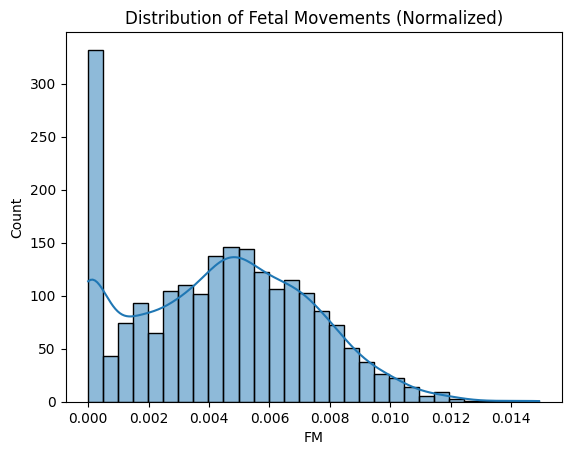

/tmp/ipython-input-2739345943.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="FM", data=df, palette="Set2")


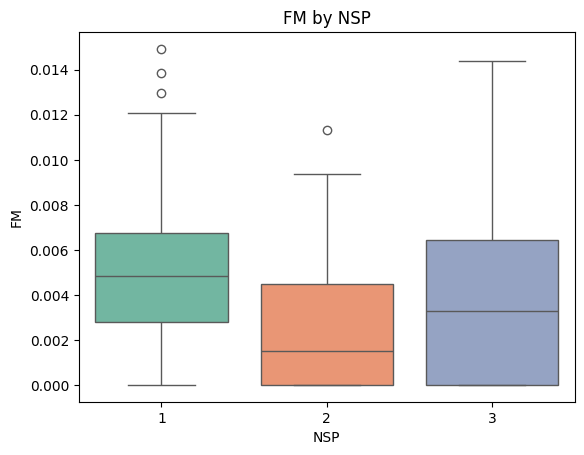

In [6]:
sns.histplot(df["FM"], kde=True, bins=30)
plt.title("Distribution of Fetal Movements (Normalized)")
plt.show()

sns.boxplot(x="NSP", y="FM", data=df, palette="Set2")
plt.title("FM by NSP")
plt.show()

Fetal movements indicate fetal activity. Abnormal patterns could show reduced oxygenation.

#**FINDINGS**

The raw fetal movements (FM_raw) are heavily skewed toward zero.

Many samples have 0 movements recorded.

A few samples have very high counts (100–500+), creating long tails.

The normalized version (FM) smooths this, showing most values clustered near 0–0.1, with a few reaching ~0.4.

Boxplot by NSP shows:

Normal cases (NSP = 1): wider spread, including higher FM counts.

Suspect and Pathological cases (NSP = 2 & 3): mostly close to zero, with rare higher values.


#**Interpretation**

Higher fetal movement counts appear more often in normal cases, suggesting that active fetal behavior is associated with good outcomes.

Low or absent movements dominate in suspect/pathological cases, which may reflect fetal distress or reduced activity.

This matches clinical knowledge: fetal inactivity or reduced movement is often a warning sign.

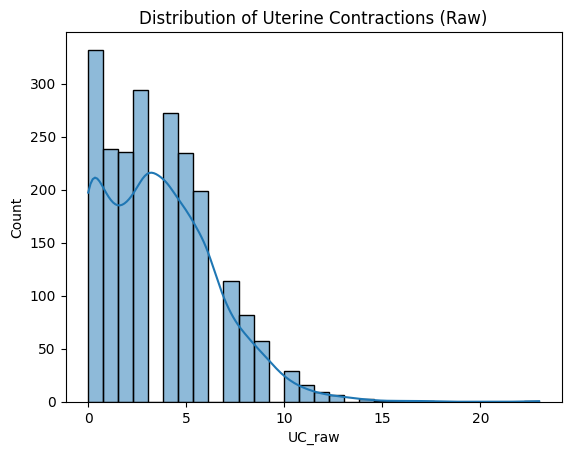

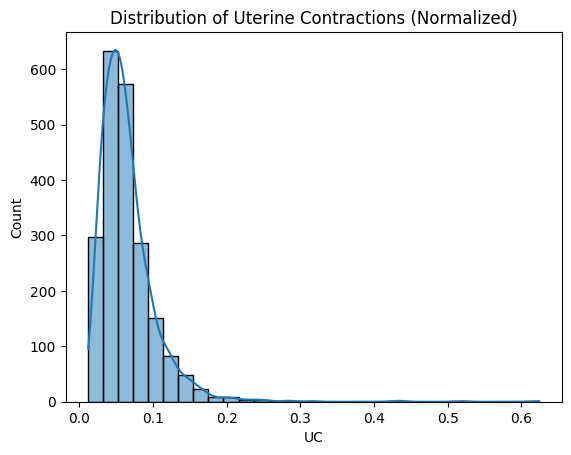

/tmp/ipython-input-2086681869.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="UC", data=df, palette="Set2")


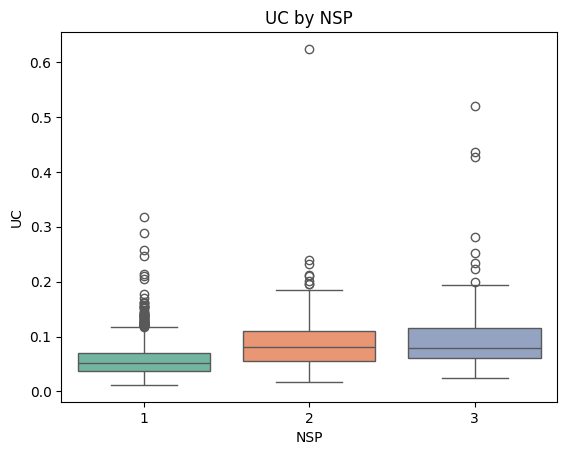

In [7]:
sns.histplot(df["UC_raw"], kde=True, bins=30)
plt.title("Distribution of Uterine Contractions (Raw)")
plt.show()

sns.histplot(df["UC"], kde=True, bins=30)
plt.title("Distribution of Uterine Contractions (Normalized)")
plt.show()

sns.boxplot(x="NSP", y="UC", data=df, palette="Set2")
plt.title("UC by NSP")
plt.show()

Contractions put stress on fetus; abnormal UC with decelerations may indicate risk.

#**Findings:**

Raw UC (UC_raw) distribution is heavily skewed toward zero, with most samples showing very few contractions.

A small number of cases have higher UC counts, but these are rare.

Boxplot by NSP:

Normal (NSP = 1): UC values spread more widely, with some high outliers.

Suspect/Pathological (NSP = 2 & 3): mostly clustered near 0.

#**Interpretation:**

Frequent uterine contractions appear more often in normal cases.

Low/no contractions are more typical in suspect/pathological groups.

Clinically, this makes sense — adequate contractions may be linked to normal outcomes, while absence or abnormal contraction patterns may suggest risk.



/tmp/ipython-input-90775852.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="ASTV", data=df, palette="Set2")


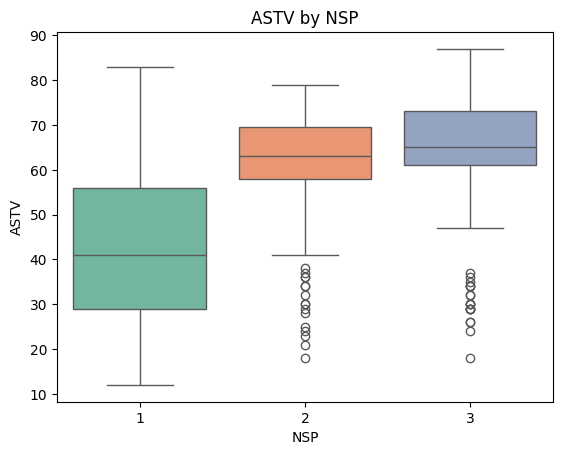

/tmp/ipython-input-90775852.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="MSTV", data=df, palette="Set2")


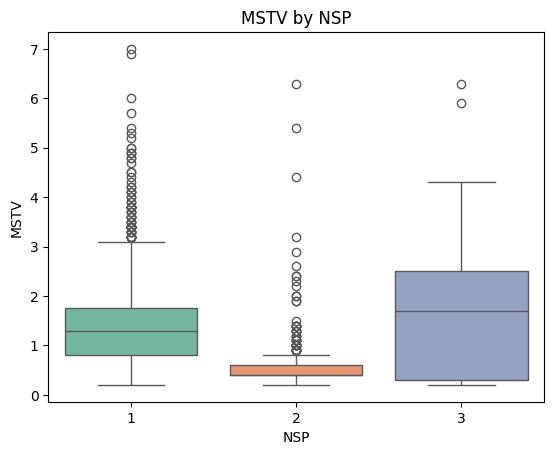

/tmp/ipython-input-90775852.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="ALTV", data=df, palette="Set2")


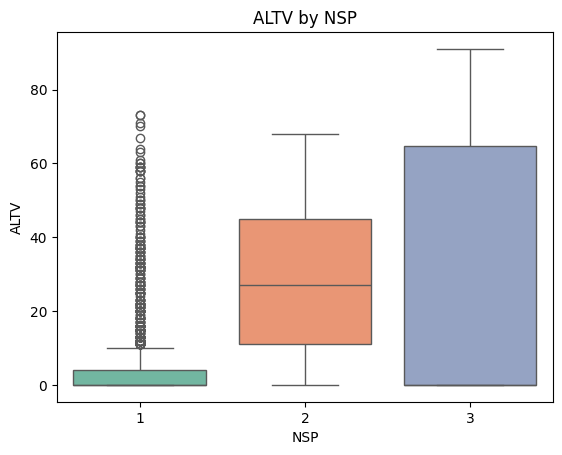

/tmp/ipython-input-90775852.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="MLTV", data=df, palette="Set2")


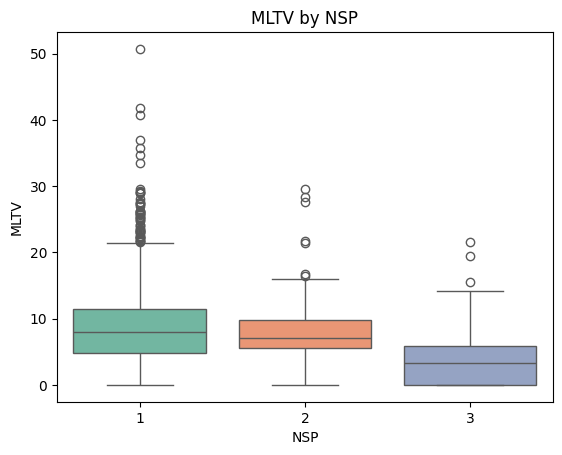

In [8]:
sns.boxplot(x="NSP", y="ASTV", data=df, palette="Set2")
plt.title("ASTV by NSP")
plt.show()

sns.boxplot(x="NSP", y="MSTV", data=df, palette="Set2")
plt.title("MSTV by NSP")
plt.show()

sns.boxplot(x="NSP", y="ALTV", data=df, palette="Set2")
plt.title("ALTV by NSP")
plt.show()

sns.boxplot(x="NSP", y="MLTV", data=df, palette="Set2")
plt.title("MLTV by NSP")
plt.show()

Variability is crucial — reduced variability suggests hypoxia or neurological issues.

# ASTV by NSP

## **Finding:**

NSP=1 has lower ASTV (around 40% median).

NSP=2 and NSP=3 show much higher ASTV medians (60–70%).

Outliers are present in all groups, especially on the low side.

## **Interpretation:**

Higher ASTV (abnormal short-term variability) is
linked with non-normal cases (NSP=2,3).

This makes ASTV a strong predictor of fetal risk.


# MSTV by NSP

## **Finding:**

NSP=2 has extremely low MSTV (median ≈ 0.5), tightly clustered.

NSP=1 and NSP=3 have wider spread, with many outliers up to 6–7.

## **Interpretation:**

Very low MSTV could be a marker for abnormal conditions.

NSP=3 also shows higher values, indicating instability.

# ALTV by NSP

# ** Finding:**

NSP=1 has very low ALTV (near 0), with many outliers.

NSP=2 and NSP=3 have higher medians and much wider spread (up to 80–90).

## **Interpretation:**

Abnormal long-term variability increases in riskier cases (NSP=2,3).

NSP=1 being concentrated near 0 makes sense (healthy baseline).

# MLTV by NSP

## **Finding:**

NSP=1 has higher MLTV spread.

NSP=2 slightly lower.

NSP=3 much lower, concentrated around 0–5.

## **Interpretation:**

Lower MLTV in NSP=3 may indicate suppressed variability under abnormal conditions.

/tmp/ipython-input-4157906436.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="DL", data=df, palette="Set2")


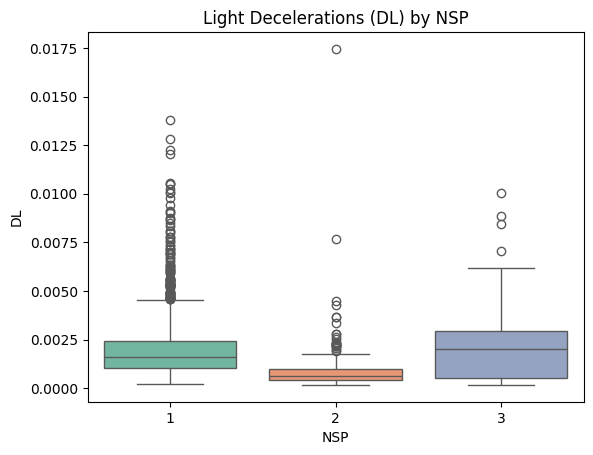

/tmp/ipython-input-4157906436.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="DS", data=df, palette="Set2")


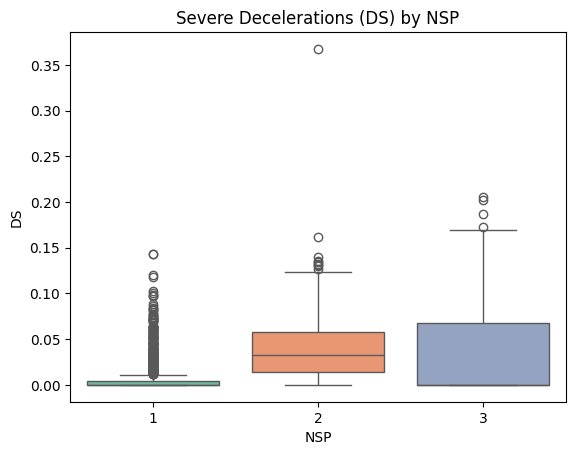

/tmp/ipython-input-4157906436.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="DP", data=df, palette="Set2")


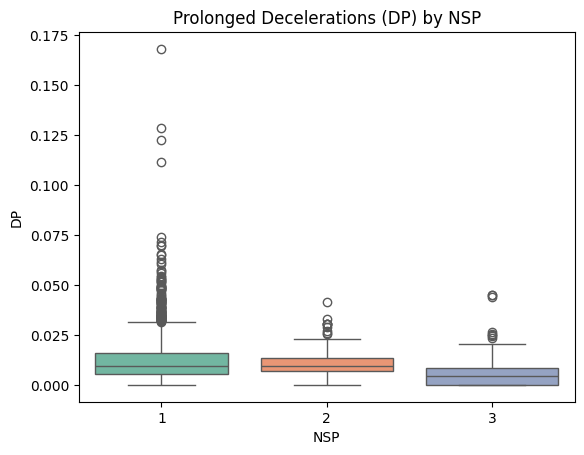

/tmp/ipython-input-4157906436.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="DR", data=df, palette="Set2")


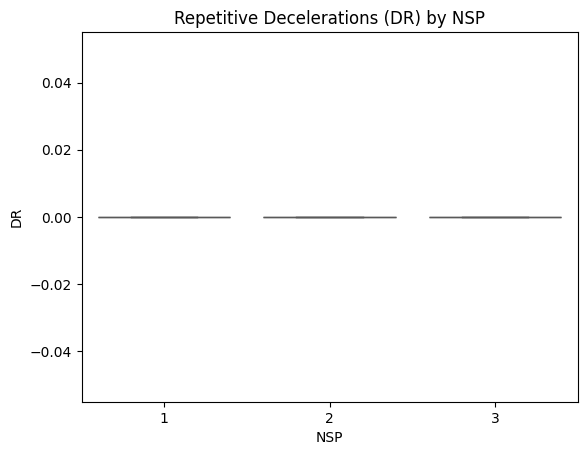

In [9]:
sns.boxplot(x="NSP", y="DL", data=df, palette="Set2")
plt.title("Light Decelerations (DL) by NSP")
plt.show()

sns.boxplot(x="NSP", y="DS", data=df, palette="Set2")
plt.title("Severe Decelerations (DS) by NSP")
plt.show()

sns.boxplot(x="NSP", y="DP", data=df, palette="Set2")
plt.title("Prolonged Decelerations (DP) by NSP")
plt.show()

sns.boxplot(x="NSP", y="DR", data=df, palette="Set2")
plt.title("Repetitive Decelerations (DR) by NSP")
plt.show()


# DL (Light Decelerations) by NSP

## **Finding:**

All groups have mostly very low DL values, but NSP=1 has more frequent light decelerations.

NSP=3 shows slightly higher medians than NSP=2.

## **Interpretation:**

Light decelerations happen often even in normal cases → less discriminative.

Still, slight differences might help when combined with other features.

## **Data Quality:**

Feature is highly skewed.

Keep but consider log-transform.

# DS (Severe Decelerations) by NSP

## **Finding:**

NSP=1: almost all values near 0.

NSP=2 and NSP=3: higher medians and more spread, some extreme cases (>0.3).

## **Interpretation:**

Severe decelerations are rare but appear mostly in abnormal outcomes.

Strong predictor despite low frequency.

## **Data Quality:**

Many zeros → sparse variable.

Keep it (don’t drop rare values).

# DP (Prolonged Decelerations) by NSP

## **Finding:**

Almost all near zero.

A few strong outliers in NSP=1 and NSP=2.

## **Interpretation:**

Rare but clinically significant events.

When present, they can indicate fetal stress.

## **Data Quality:**

Highly imbalanced (mostly zero).

Keep, but maybe binarize (0 = none, >0 = present) if models struggle.

# DR (Repetitive Decelerations) by NSP

## **Finding:**

Flat line at 0 across all NSP groups.

## **Interpretation:**

No variation → offers no predictive power.

## **Data Quality:**

Can safely drop this feature since it’s constant.

/tmp/ipython-input-3432293204.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="Variance", data=df, palette="Set2")


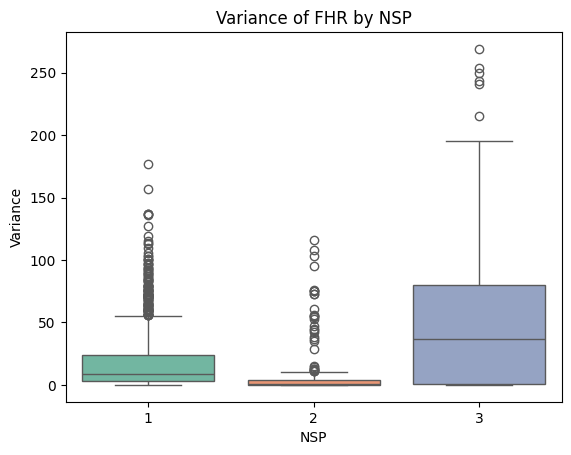

/tmp/ipython-input-3432293204.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="NSP", y="Mean", data=df, palette="Set2")


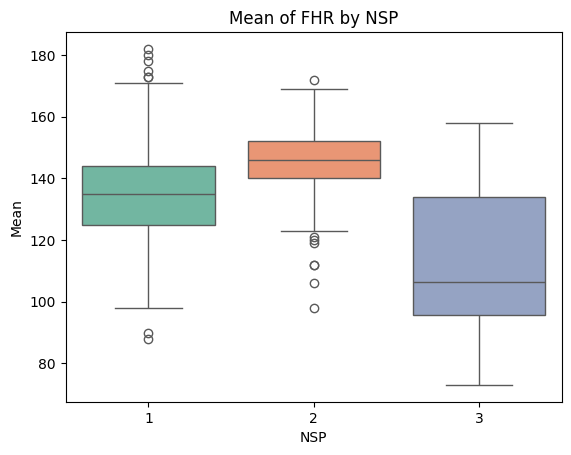

In [10]:
sns.boxplot(x="NSP", y="Variance", data=df, palette="Set2")
plt.title("Variance of FHR by NSP")
plt.show()

sns.boxplot(x="NSP", y="Mean", data=df, palette="Set2")
plt.title("Mean of FHR by NSP")
plt.show()


# Variance of FHR by NSP

## **Findings:**

Normal cases (NSP=1) have very low variance, mostly under 20.

Pathological cases (NSP=3) show extremely high variance, sometimes above 200.

There are many outliers across all classes.

## **Interpretation:**

Low variance in FHR is linked with stable heart rates (healthy fetuses).

High variance in pathological cases suggests instability or irregular fluctuations.

This feature clearly distinguishes normal vs. pathological.

## **Data Quality:**

High outlier concentration → may need transformation (log-scaling).

Keep the data but consider robust scaling.

# Mean of FHR by NSP

## **Findings:**

Normal cases center around 130–140 bpm.

Suspect cases are slightly higher (140–150 bpm).

Pathological cases often drop below 120 bpm.

## **Interpretation:**

Mean FHR is clinically important.

A lower mean is a red flag for fetal distress (e.g., hypoxia).

Useful as a strong predictive variable.

## **Data Quality:**

Some extreme outliers (means as low as 80 and as high as 180).

Consider capping or trimming extreme values.

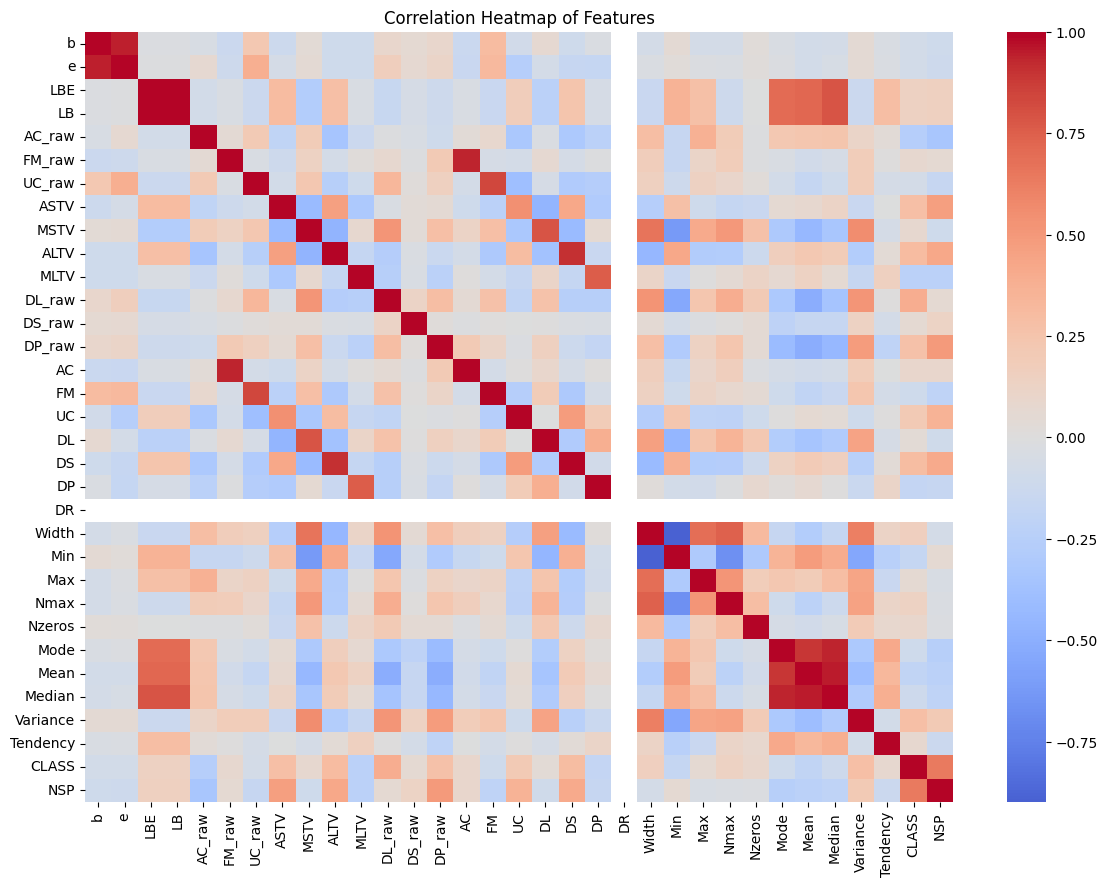

In [11]:
plt.figure(figsize=(14,10))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Features")
plt.show()

# Correlation Heatmap of Features

## **Findings:**

Strong correlation between some derived features (e.g., AC_raw vs AC, FM_raw vs FM).

Variance, Mean, Median are interdependent.

NSP is negatively correlated with AC, FM, and positively with Variance.

## **Interpretation:**

Some features may be redundant (e.g., raw vs. normalized values).

Correlation helps identify collinearity issues for modeling.

## **Data Quality:**

No missing patterns, but multicollinearity must be addressed (feature selection or PCA).

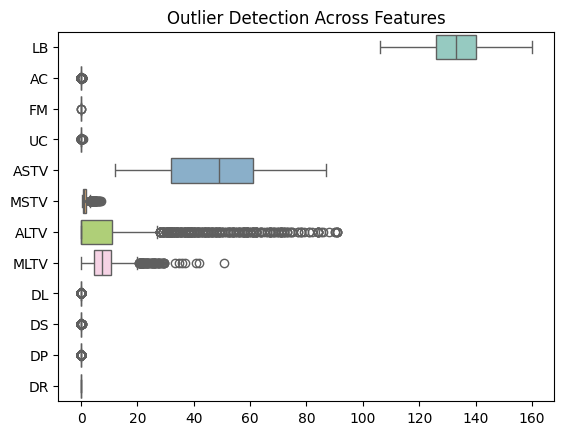

In [12]:
sns.boxplot(data=df[["LB","AC","FM","UC","ASTV","MSTV","ALTV","MLTV","DL","DS","DP","DR"]],
            orient="h", palette="Set3")
plt.title("Outlier Detection Across Features")
plt.show()

# Outlier Detection Across Features

## **Findings:**

ALTV and MLTV have extreme spread with many outliers.

Deceleration features (DL, DS, DP) mostly centered near 0, with rare spikes.

LB, ASTV more stable and less noisy.

## **Interpretation:**

Some features naturally skewed (because events like decelerations are rare).

Outliers may reflect true rare events, not just noise.

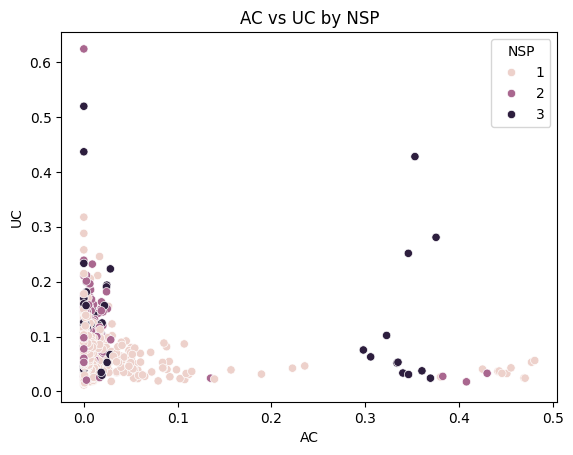

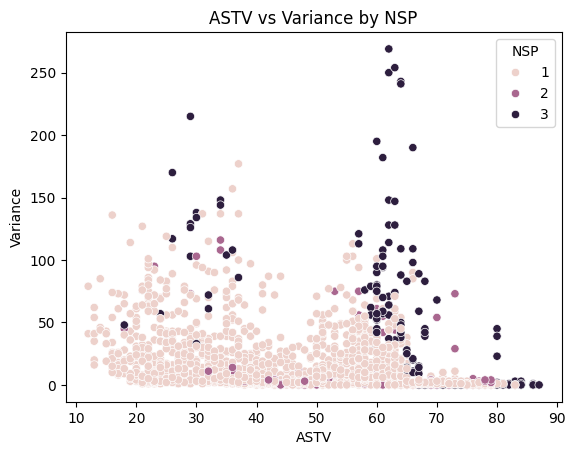

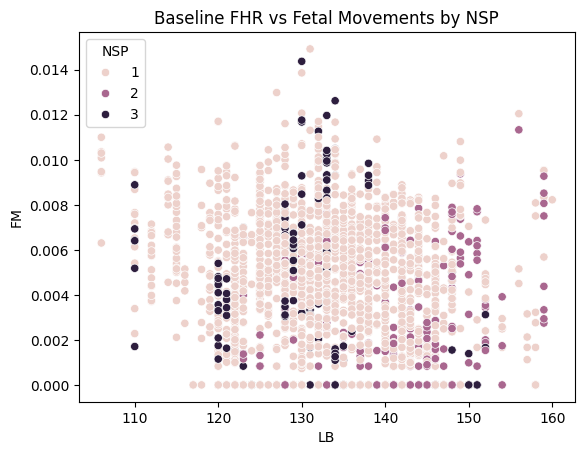

In [13]:
sns.scatterplot(x="AC", y="UC", hue="NSP", data=df)
plt.title("AC vs UC by NSP")
plt.show()

sns.scatterplot(x="ASTV", y="Variance", hue="NSP", data=df)
plt.title("ASTV vs Variance by NSP")
plt.show()

sns.scatterplot(x="LB", y="FM", hue="NSP", data=df)
plt.title("Baseline FHR vs Fetal Movements by NSP")
plt.show()


# AC vs UC by NSP

## **Findings:**
Most points cluster near low values of AC (accelerations) and UC (uterine contractions). Some points show higher AC values (~0.3–0.5), but these are relatively rare. NSP 1 (normal) dominates the low values, while NSP 2 and 3 (suspect/pathologic) appear more frequently when AC is slightly higher.

## **Interpretation:**
In normal conditions, fetal accelerations are generally present but not extreme, while excessive uterine contractions are rare. Abnormal NSP cases (2 and 3) sometimes show unusual acceleration-contraction combinations, which may indicate distress or atypical fetal response.



# ASTV vs Variance by NSP

## **Findings:**
There is a wide spread in variance of FHR across different ASTV (percentage of abnormal short-term variability) levels. Higher ASTV (>60) tends to correlate with higher variance, especially for NSP 3 (pathologic). NSP 1 mostly clusters at moderate ASTV and low variance.

## **Interpretation:**
This suggests that abnormal variability in heart rate is strongly associated with higher overall variance, a marker of fetal distress. NSP 3 cases stand out clearly, making ASTV + Variance a potentially discriminative feature for classification.



# Baseline FHR (LB) vs Fetal Movements (FM) by NSP

## **Findings:**
Most baseline fetal heart rates cluster between 120–150 bpm, consistent with physiological norms. Fetal movements (FM) are concentrated near zero, with very few cases showing higher values. Distribution of NSP is fairly mixed across LB, but FM does not clearly separate classes.

## **Interpretation:**
Baseline FHR aligns with expected clinical ranges. However, FM alone may not be a strong predictor of NSP—it is relatively flat across categories. The interaction between LB and FM doesn’t produce distinct clusters for classification.


Dropped due to correlation: ['e', 'LB', 'AC', 'DS', 'Median']
     Feature  Importance
26     CLASS    0.318819
5       ASTV    0.087712
6       MSTV    0.082047
7       ALTV    0.074607
23      Mean    0.067800
22      Mode    0.042103
14        DL    0.035308
11    DP_raw    0.032002
8       MLTV    0.025127
2     AC_raw    0.024564
24  Variance    0.024212
18       Min    0.020152
1        LBE    0.019962
17     Width    0.019099
15        DP    0.018418
13        UC    0.017928
12        FM    0.017600
4     UC_raw    0.016551
19       Max    0.013941
0          b    0.013539
20      Nmax    0.009175
3     FM_raw    0.007297
9     DL_raw    0.006920
25  Tendency    0.003544
21    Nzeros    0.001230
10    DS_raw    0.000341
16        DR    0.000000


/tmp/ipython-input-183139252.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances, x="Importance", y="Feature", palette="viridis")


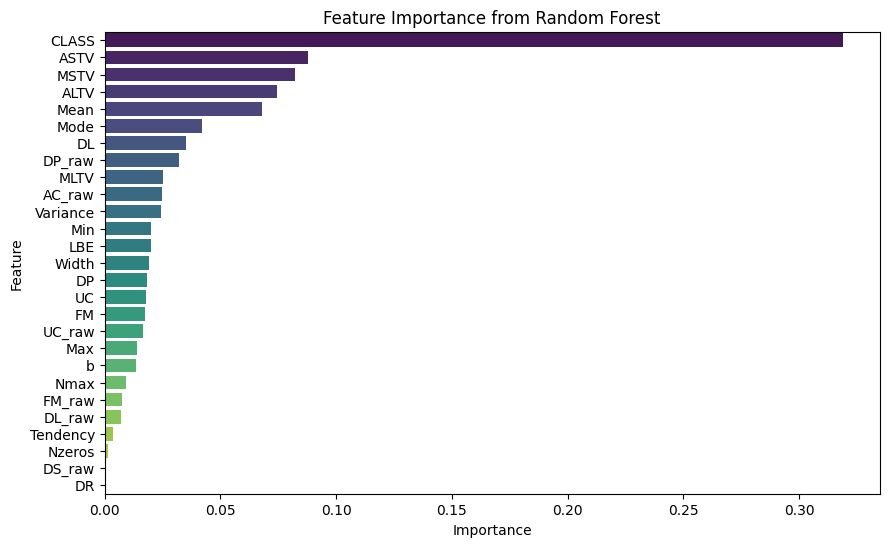

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset
df = pd.read_excel("data_cardio.xlsx", sheet_name="Raw Data")  # adjust sheet name if needed

# Drop columns not needed (like ID if present)
# df = df.drop(columns=["ID"])  # Uncomment if you have ID

# Define features and target
X = df.drop(columns=["NSP"])   # NSP is the target variable
y = df["NSP"]

# -------------------------
# 1. CORRELATION PRUNING
# -------------------------
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation > 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X_reduced = X.drop(columns=to_drop)

print("Dropped due to correlation:", to_drop)

# -------------------------
# 2. FEATURE IMPORTANCE with Random Forest
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

# Scale features (optional, good for skewed data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_scaled, y_train)

importances = pd.DataFrame({
    "Feature": X_reduced.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(importances)

# -------------------------
# 3. VISUALIZATION
# -------------------------
plt.figure(figsize=(10,6))
sns.barplot(data=importances, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance from Random Forest")
plt.show()


/tmp/ipython-input-1292210043.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")


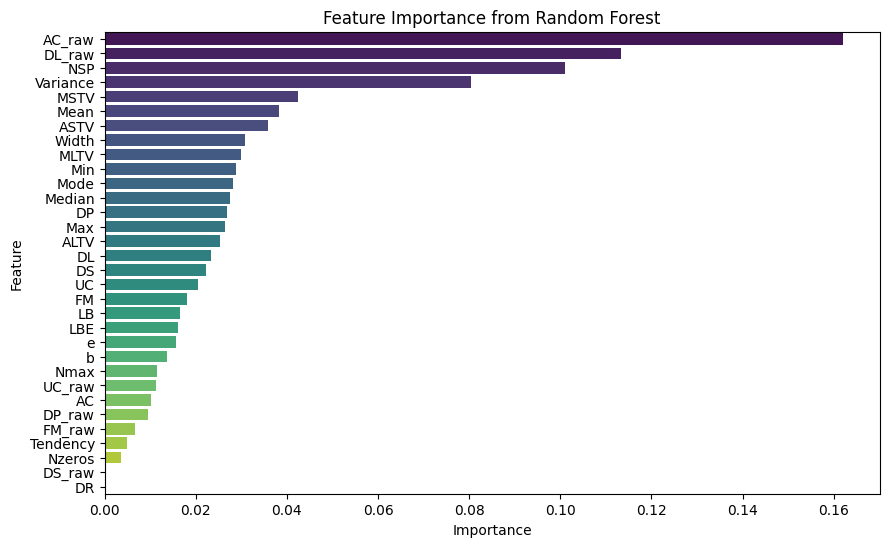

In [15]:
# Define features and target
X = df.drop(columns=["CLASS"])   # CLASS is the target
y = df["CLASS"]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Feature importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

importances = rf.feature_importances_
feat_imp = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feat_imp, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance from Random Forest")
plt.show()


# **Strong Predictors (Key Features)**

These consistently showed strong separation between classes (NSP 1, 2, 3) and high importance in feature selection.

ASTV

MSTV

ALTV

Variance

Mean FHR

AC_raw

#  Moderate Predictors (Helpful but secondary)



LB (Baseline FHR) → within normal ranges but extreme values matter.

AC (normalized) → overlaps with AC_raw, less strong alone.

FM (normalized) → skewed toward zero, low power alone but adds context.

FM_raw → similar story; raw values had low but nonzero importance.

DL_raw → light decelerations; some predictive signal.

DP_raw → prolonged decelerations; less common but useful.

MLTV → long-term variability (lower ranked than ASTV/ALTV).

Mode / Median / Width / Max / Min → moderate contribution; statistical summaries.

# Weak Predictors (Low or redundant)



DR → already dropped; almost always zero.

DS_raw → severe decelerations, very rare, contributes little.

Nzeros → number of zeros, redundant with other features.

Tendency → weak signal, low importance across runs.

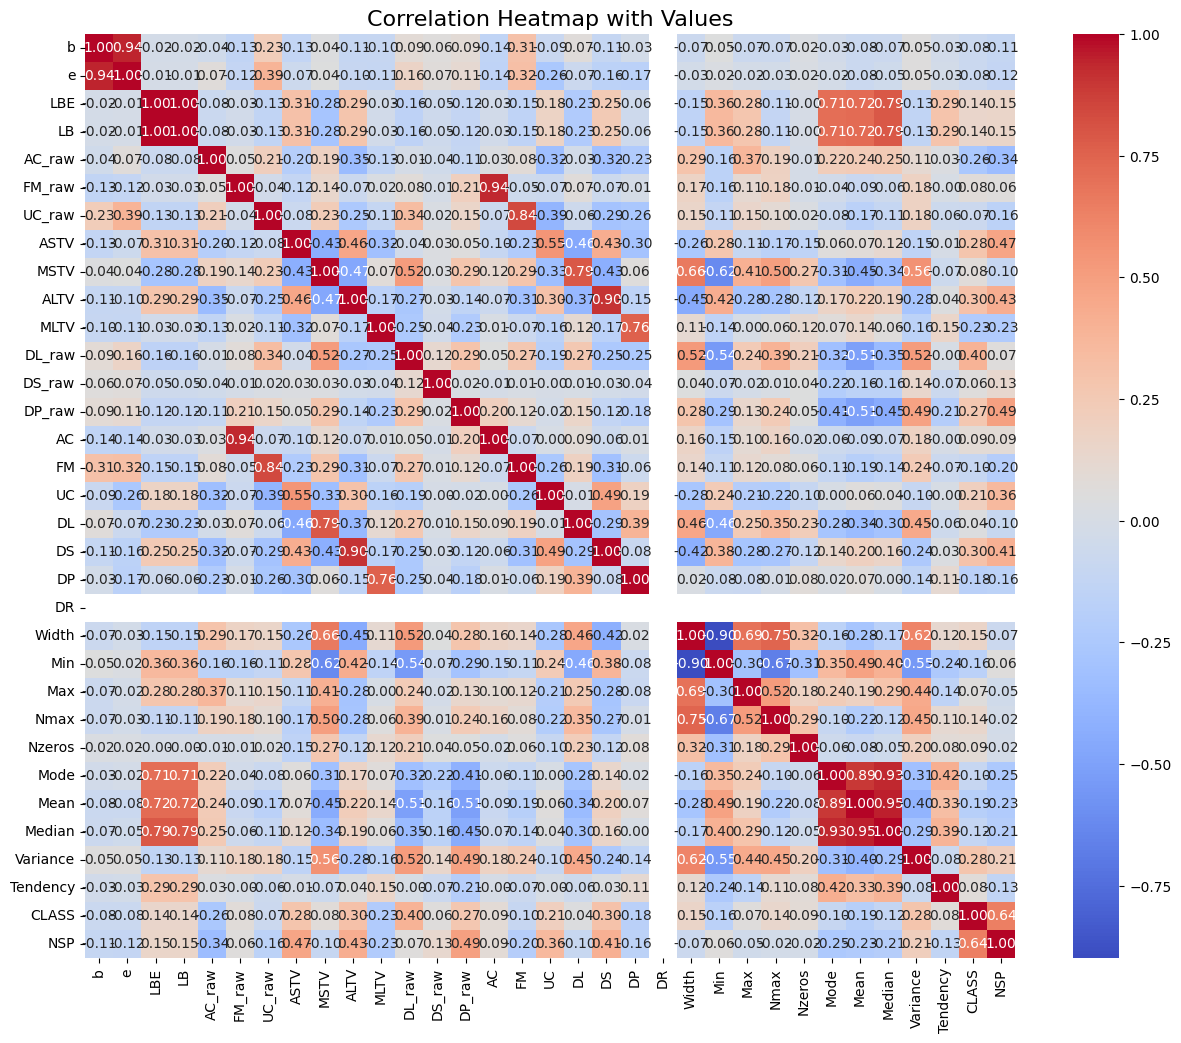

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr = df.corr()

# Plot heatmap with correlation numbers
plt.figure(figsize=(15, 12))
sns.heatmap(
    corr,
    annot=True,         # ✅ show correlation coefficients
    fmt=".2f",          # ✅ format numbers to 2 decimals
    cmap="coolwarm",    # color scheme
    cbar=True
)
plt.title("Correlation Heatmap with Values", fontsize=16)
plt.show()


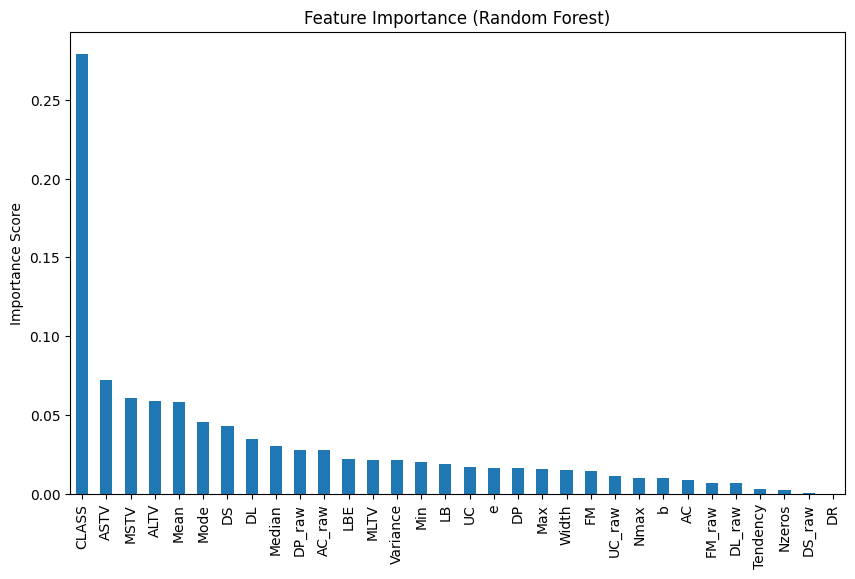

Top Predictors:
 CLASS     0.279153
ASTV      0.072109
MSTV      0.061151
ALTV      0.058723
Mean      0.058541
Mode      0.045696
DS        0.043062
DL        0.035117
Median    0.030482
DP_raw    0.027901
dtype: float64


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define X and y
X = df.drop(columns=["NSP"])
y = df["NSP"]

# Scale (not mandatory for RF, but good practice)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train RF
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Feature importances
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importances.plot(kind='bar')
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance Score")
plt.show()

print("Top Predictors:\n", feat_importances.head(10))


In [18]:
import numpy as np
from sklearn.preprocessing import RobustScaler

skewed_features = ["FM", "DL", "DS", "DP", "Variance"]
scaler = RobustScaler()
df[skewed_features] = scaler.fit_transform(df[skewed_features])

In [19]:
import pandas as pd

# exclude target column
numeric_cols = df.drop(columns=["NSP"]).select_dtypes(include=["int64", "float64"]).columns

# compute skewness
skewness = df[numeric_cols].skew().sort_values(ascending=False)
print(skewness)


DS_raw      17.353457
FM_raw       9.427496
AC           7.812157
DP_raw       4.235888
UC           3.924396
Nzeros       3.920287
DP           3.859120
DS           3.456324
Variance     3.219974
DL           2.809558
ALTV         2.195075
DL_raw       1.819119
AC_raw       1.658830
MSTV         1.657339
MLTV         1.331998
Nmax         0.892886
UC_raw       0.835346
b            0.829898
e            0.663002
Max          0.577862
CLASS        0.381163
Width        0.314235
FM           0.156377
Min          0.115784
LBE          0.020312
LB           0.020312
DR           0.000000
ASTV        -0.011829
Tendency    -0.311632
Median      -0.478414
Mean        -0.651019
Mode        -0.995178
dtype: float64


In [20]:
X = df.drop(columns=["NSP"])
y = df["NSP"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

skewed_features = skewness[skewness > 1].index

import numpy as np
for col in skewed_features:
    df[col] = np.log1p(df[col])


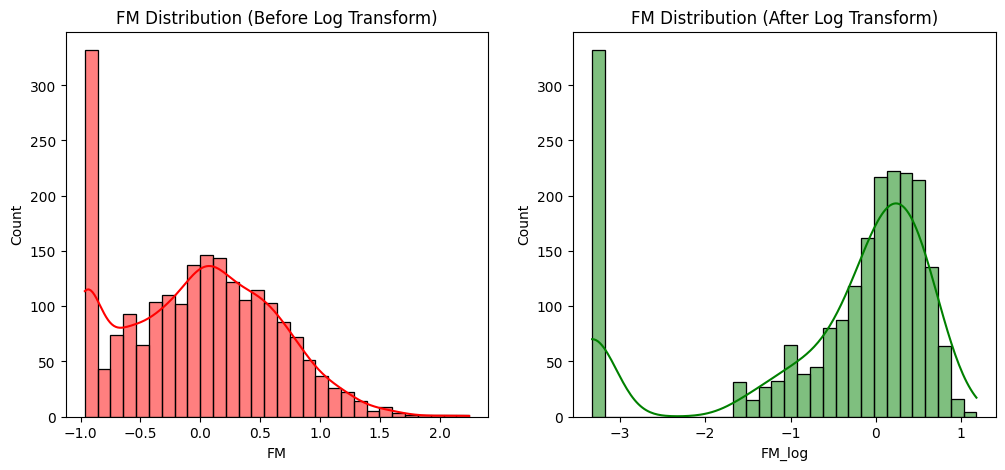

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Original distribution
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df["FM"], bins=30, kde=True, color="red")
plt.title("FM Distribution (Before Log Transform)")

# Apply log1p transform
df["FM_log"] = np.log1p(df["FM"])

# Transformed distribution
plt.subplot(1,2,2)
sns.histplot(df["FM_log"], bins=30, kde=True, color="green")
plt.title("FM Distribution (After Log Transform)")

plt.show()


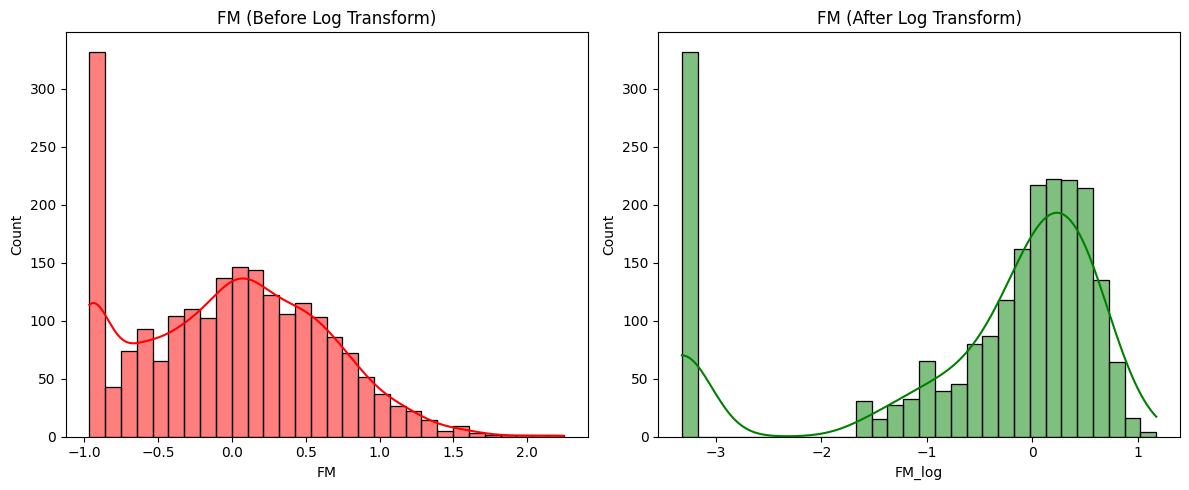

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


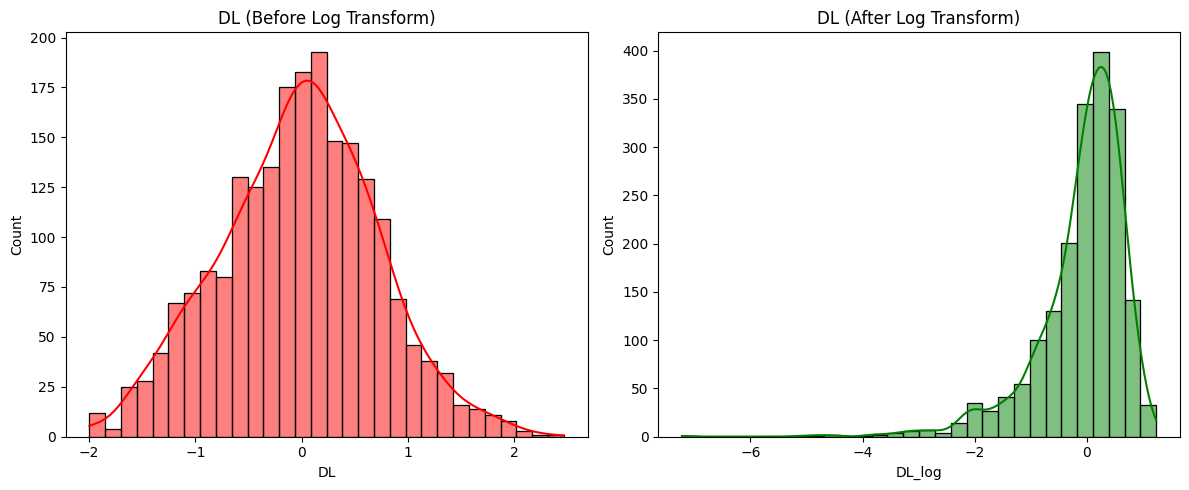

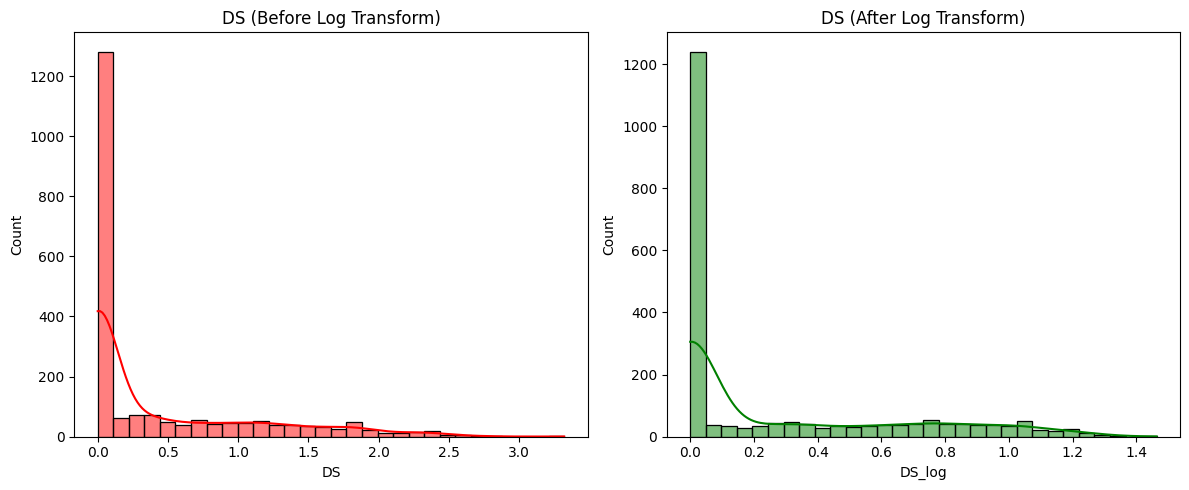

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


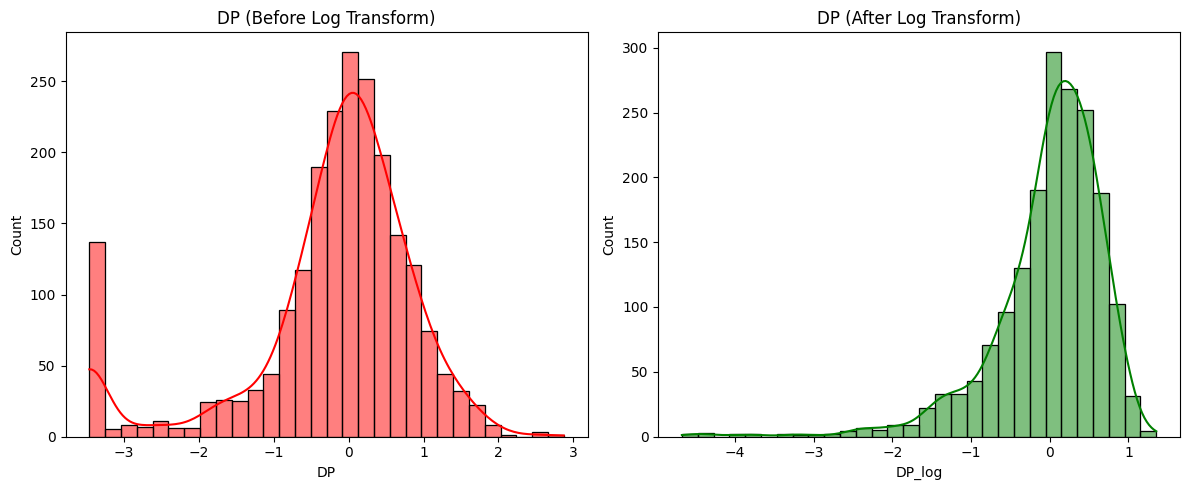

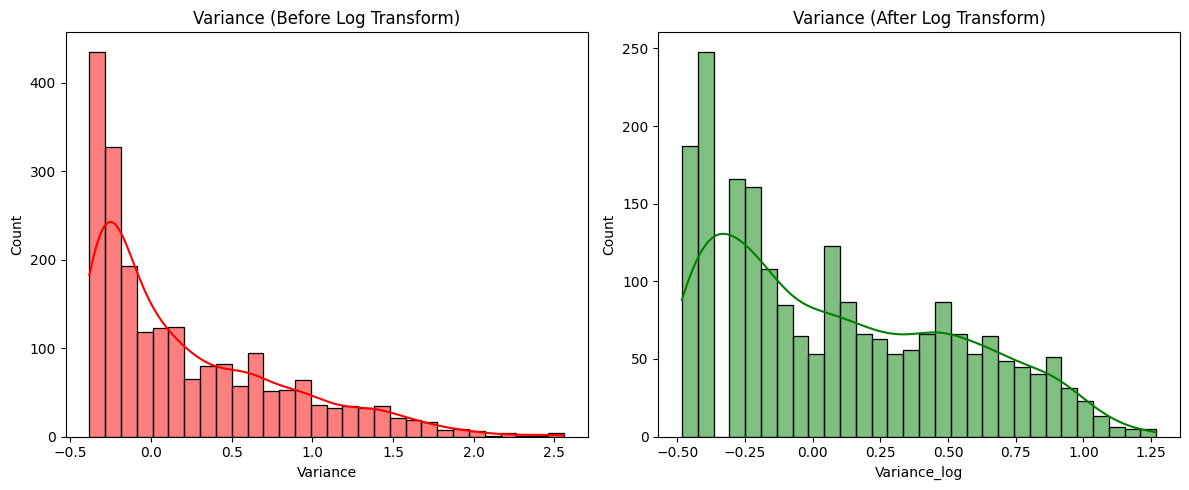

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of skewed features
skewed_features = ["FM", "DL", "DS", "DP", "Variance"]

for feature in skewed_features:
    # Create new transformed column
    df[feature + "_log"] = np.log1p(df[feature])  # log1p handles zeros

    # Plot before and after
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Before transform
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[0], color="red")
    axes[0].set_title(f"{feature} (Before Log Transform)")

    # After transform
    sns.histplot(df[feature + "_log"], bins=30, kde=True, ax=axes[1], color="green")
    axes[1].set_title(f"{feature} (After Log Transform)")

    plt.tight_layout()
    plt.show()


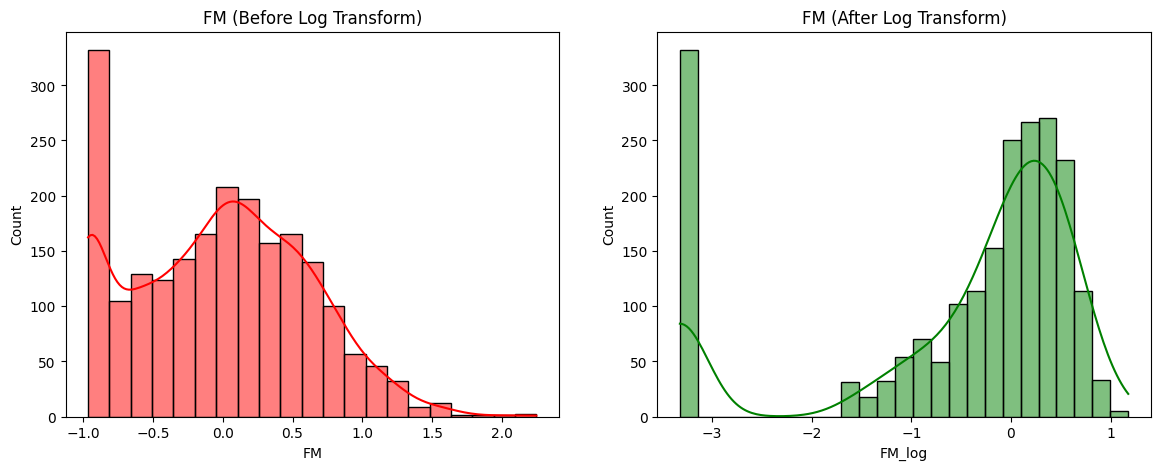

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


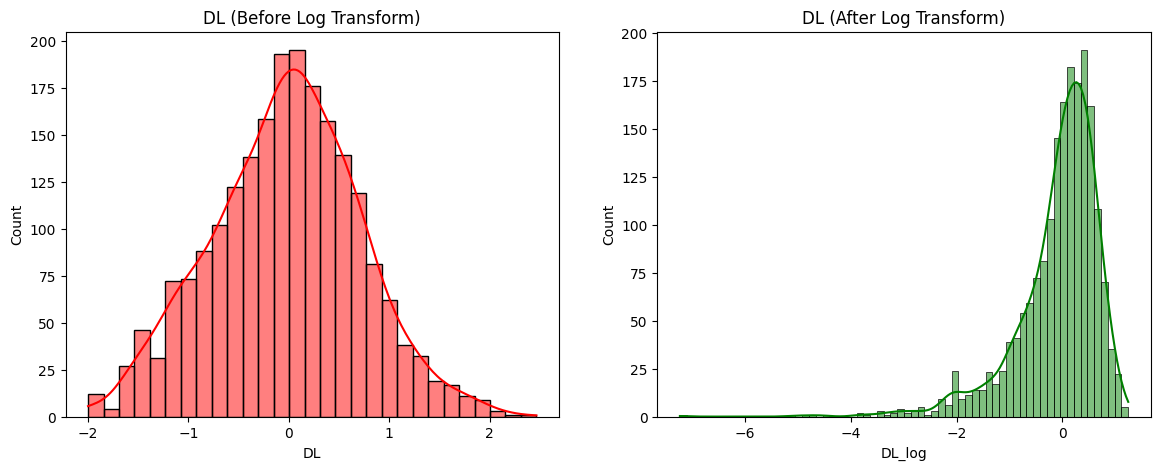

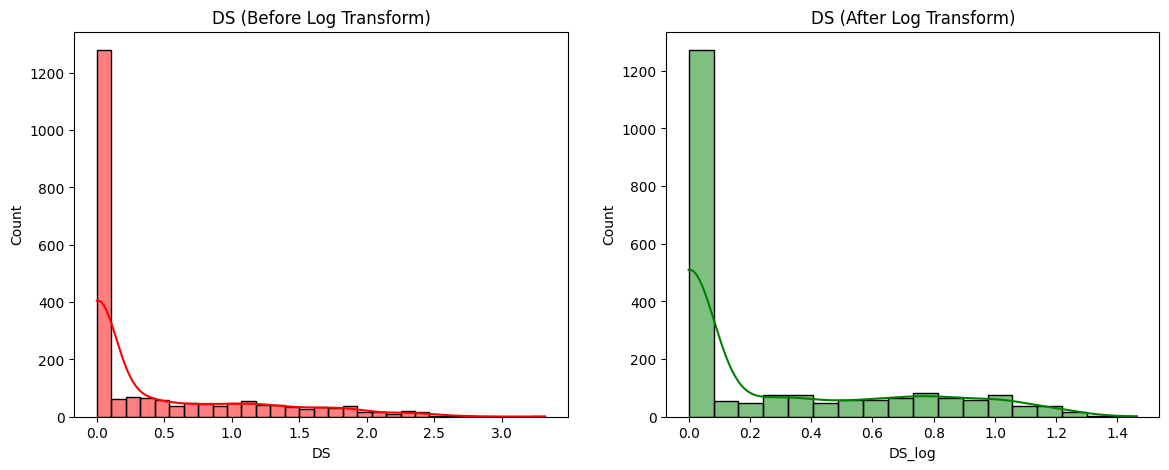

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


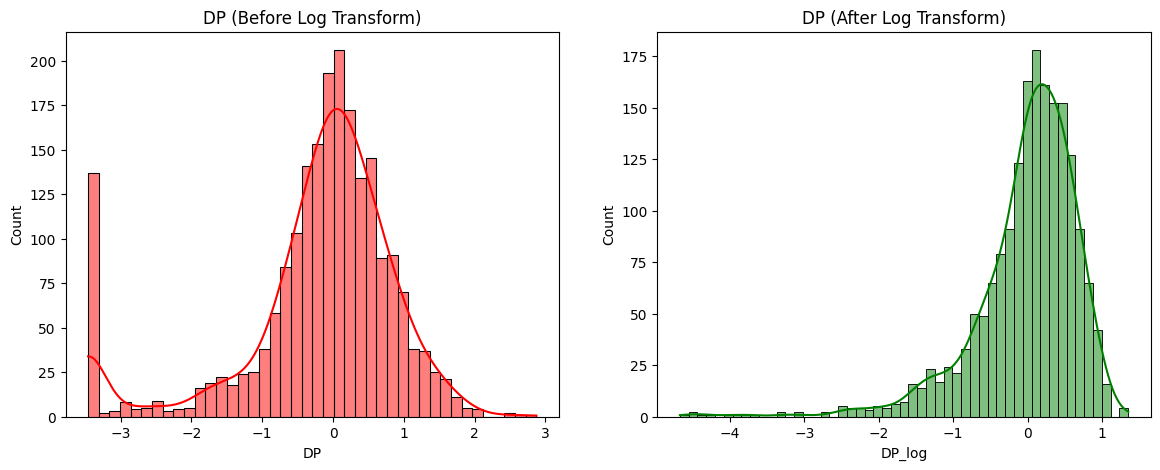

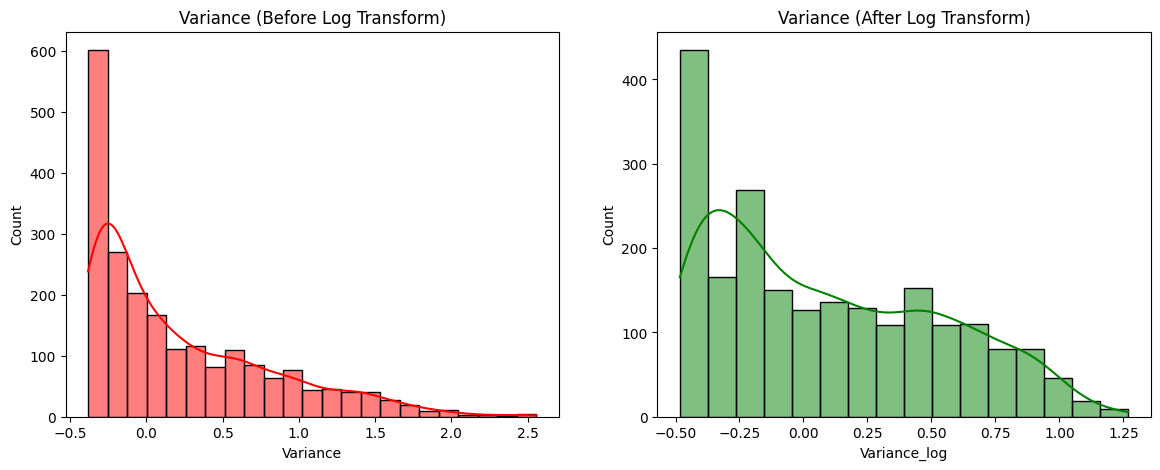

✅ New dataset with log-transformed features saved as 'transformed_dataset.xlsx'


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# List of skewed features you want to log-transform
skewed_features = ["FM", "DL", "DS", "DP", "Variance"]

for feature in skewed_features:
    # Create a new log-transformed column
    df[feature + "_log"] = np.log1p(df[feature])   # log1p handles 0 safely

    # Plot before and after
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.histplot(df[feature], kde=True, ax=axes[0], color="red")
    axes[0].set_title(f"{feature} (Before Log Transform)")

    sns.histplot(df[feature + "_log"], kde=True, ax=axes[1], color="green")
    axes[1].set_title(f"{feature} (After Log Transform)")

    plt.show()


df.to_excel("transformed_dataset.xlsx", index=False)

print("✅ New dataset with log-transformed features saved as 'transformed_dataset.xlsx'")


# Building the Model

In [24]:
df = pd.read_excel("transformed_dataset.xlsx")

In [25]:
# Stratified train/test split and class weights
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
classes = np.unique(y_train)
class_weight_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weight_values))
sample_weight_train = compute_sample_weight(class_weight='balanced', y=y_train)

distribution = (
    pd.DataFrame({
        'Split': ['Train', 'Test'],
        'Size': [len(y_train), len(y_test)],
        'Normal (1)': [np.mean(y_train == 1), np.mean(y_test == 1)],
        'Suspect (2)': [np.mean(y_train == 2), np.mean(y_test == 2)],
        'Pathologic (3)': [np.mean(y_train == 3), np.mean(y_test == 3)]
    })
    .rename(columns=lambda c: c if c in {'Split', 'Size'} else f'{c} proportion')
)
distribution, class_weight_dict

(   Split  Size  Normal (1) proportion  Suspect (2) proportion  \
 0  Train  1488               0.778226                0.139113   
 1   Test   638               0.778997                0.137931   
 
    Pathologic (3) proportion  
 0                   0.082661  
 1                   0.083072  ,
 {np.int64(1): np.float64(0.4283246977547496),
  np.int64(2): np.float64(2.396135265700483),
  np.int64(3): np.float64(4.032520325203252)})

In [26]:
results = []

def evaluate_model(name, estimator, X_train, y_train, X_test, y_test, fit_kwargs=None, display_report=True):
    fit_kwargs = fit_kwargs or {}
    # Fit model
    estimator.fit(X_train, y_train, **fit_kwargs)

    # Predict classes and probabilities
    y_pred = estimator.predict(X_test)
    if hasattr(estimator, "predict_proba"):
        y_pred_proba = estimator.predict_proba(X_test)  # shape: (n_samples, n_classes)
    else:
        y_pred_proba = None

    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # Save results summary
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Balanced Accuracy': bal_acc,
        'Precision Macro': precision_macro,
        'Recall Macro': recall_macro,
        'F1 Macro': f1_macro,
        'Precision Weighted': precision_weighted,
        'Recall Weighted': recall_weighted,
        'F1 Weighted': f1_weighted
    })

    # Print metrics summary
    print(f"{name} — Accuracy: {accuracy:.3f}, Balanced Accuracy: {bal_acc:.3f}")
    print(f"Precision (macro): {precision_macro:.3f}, Recall (macro): {recall_macro:.3f}, F1 (macro): {f1_macro:.3f}")
    print(f"Precision (weighted): {precision_weighted:.3f}, Recall (weighted): {recall_weighted:.3f}, F1 (weighted): {f1_weighted:.3f}")

    # Print classification report
    if display_report:
        print(f"\nClassification Report for {name}:")
        print(classification_report(y_test, y_pred, digits=3, zero_division=0))

    # Plot normalized confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        labels=getattr(estimator, "classes_", None),
        normalize='true',
        cmap='Blues'
    )
    disp.ax_.set_title(f"{name} — Normalized Confusion Matrix")
    plt.show()

    # ROC AUC for multiclass if probabilities available
    if y_pred_proba is not None:
        from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve # Import roc_curve and auc
        roc_auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
        roc_auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='macro')
        print(f"ROC AUC OVR (macro): {roc_auc_ovr:.3f}")
        print(f"ROC AUC OVO (macro): {roc_auc_ovo:.3f}")

        # Plot ROC curves per class (One-vs-Rest)
        classes = getattr(estimator, "classes_", np.unique(y_test))
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve((y_test == cls).astype(int), y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'Class {cls} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} — ROC Curves (One-vs-Rest)')
        plt.legend(loc='lower right')
        plt.show()

        # Plot Precision-Recall curves per class
        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            precision, recall, _ = precision_recall_curve((y_test == cls).astype(int), y_pred_proba[:, i])
            plt.plot(recall, precision, lw=2, label=f'Class {cls}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{name} — Precision-Recall Curves')
        plt.legend(loc='best')
        plt.show()

    return estimator, y_pred

  ## **Logistics Regression** (Supervised Learning)

Logistic Regression — Accuracy: 0.947, Balanced Accuracy: 0.882
Precision (macro): 0.867, Recall (macro): 0.882, F1 (macro): 0.873
Precision (weighted): 0.949, Recall (weighted): 0.947, F1 (weighted): 0.947

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1      0.990     0.974     0.982       497
           2      0.806     0.898     0.849        88
           3      0.804     0.774     0.788        53

    accuracy                          0.947       638
   macro avg      0.867     0.882     0.873       638
weighted avg      0.949     0.947     0.947       638



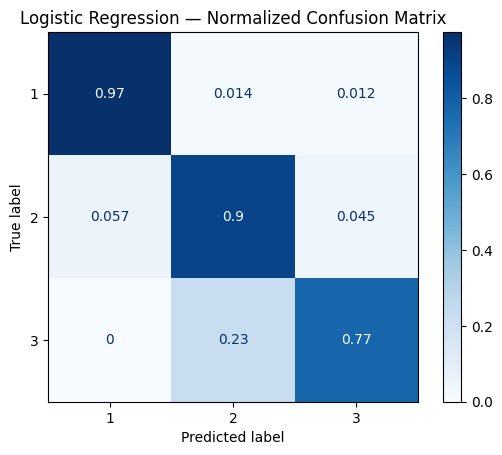

ROC AUC OVR (macro): 0.985
ROC AUC OVO (macro): 0.971


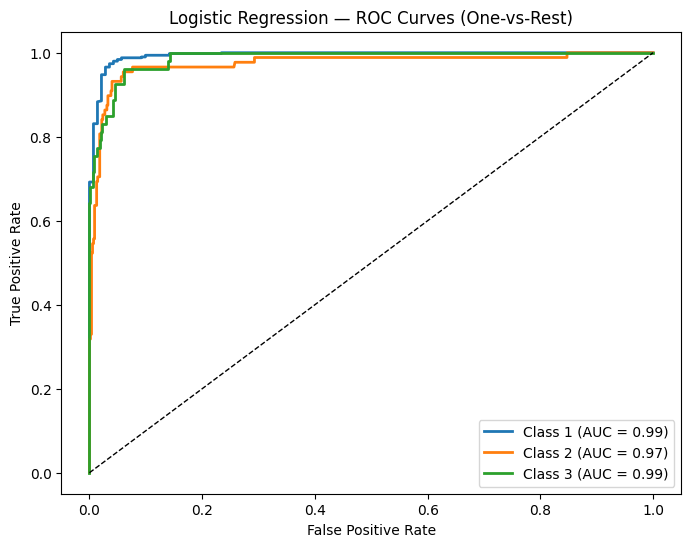

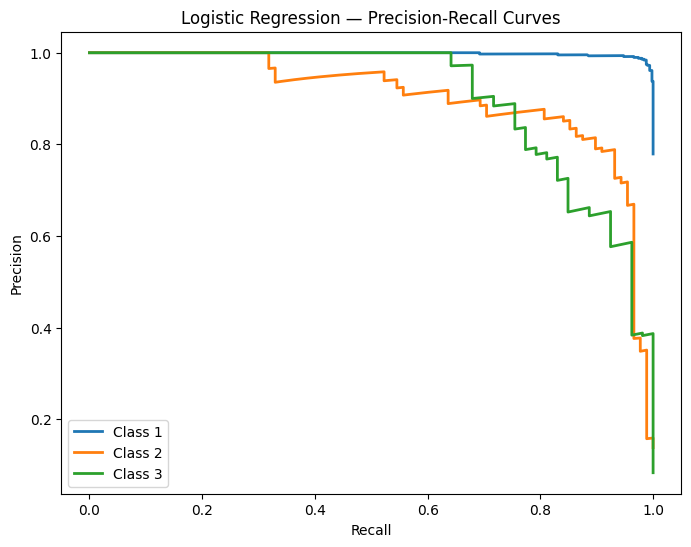

In [27]:
logreg_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])
_ = evaluate_model('Logistic Regression', logreg_pipeline, X_train, y_train, X_test, y_test)

## **K-Nearest Neighbors (KNN)** (Unsupervised Learning)

K-Nearest Neighbors — Accuracy: 0.929, Balanced Accuracy: 0.792
Precision (macro): 0.874, Recall (macro): 0.792, F1 (macro): 0.826
Precision (weighted): 0.926, Recall (weighted): 0.929, F1 (weighted): 0.926

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           1      0.955     0.992     0.973       497
           2      0.798     0.761     0.779        88
           3      0.868     0.623     0.725        53

    accuracy                          0.929       638
   macro avg      0.874     0.792     0.826       638
weighted avg      0.926     0.929     0.926       638



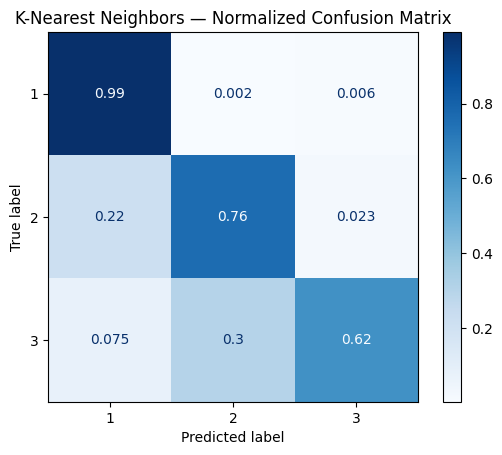

ROC AUC OVR (macro): 0.962
ROC AUC OVO (macro): 0.946


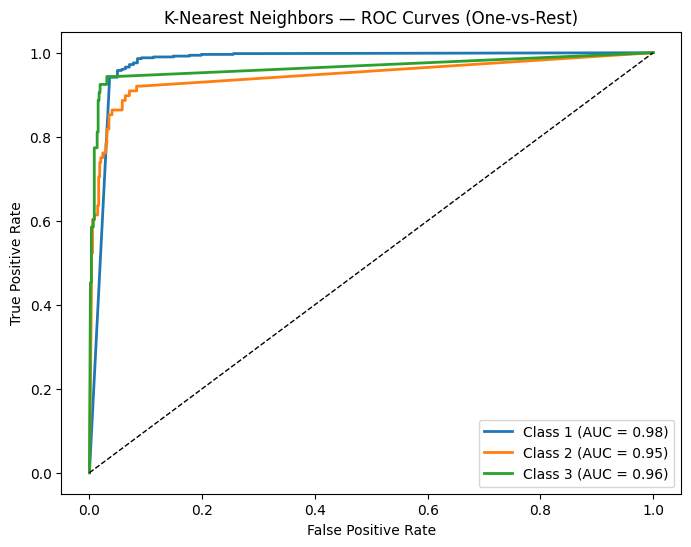

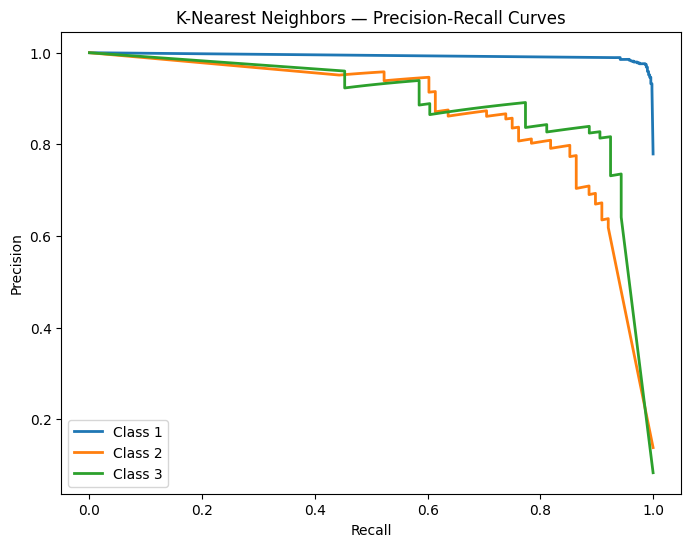

In [28]:
knn_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        n_jobs=-1
    ))
])
_ = evaluate_model('K-Nearest Neighbors', knn_pipeline, X_train, y_train, X_test, y_test)


  ## **Decision Trees** (Supervised Learning)

Decision Tree — Accuracy: 0.978, Balanced Accuracy: 0.966
Precision (macro): 0.971, Recall (macro): 0.966, F1 (macro): 0.968
Precision (weighted): 0.978, Recall (weighted): 0.978, F1 (weighted): 0.978

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           1      0.984     0.988     0.986       497
           2      0.930     0.909     0.920        88
           3      1.000     1.000     1.000        53

    accuracy                          0.978       638
   macro avg      0.971     0.966     0.968       638
weighted avg      0.978     0.978     0.978       638



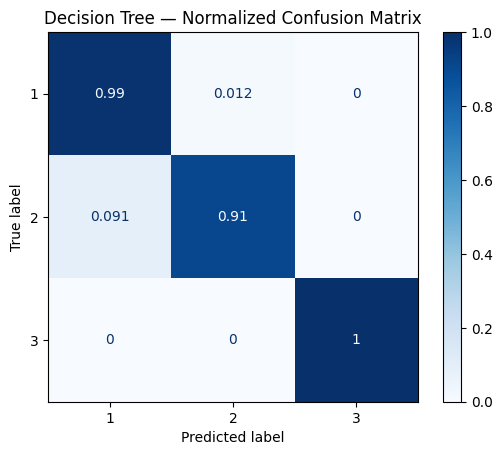

ROC AUC OVR (macro): 0.980
ROC AUC OVO (macro): 0.982


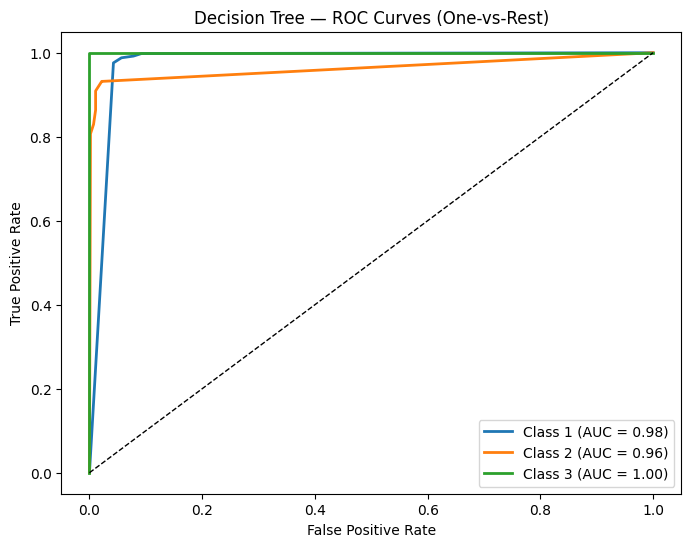

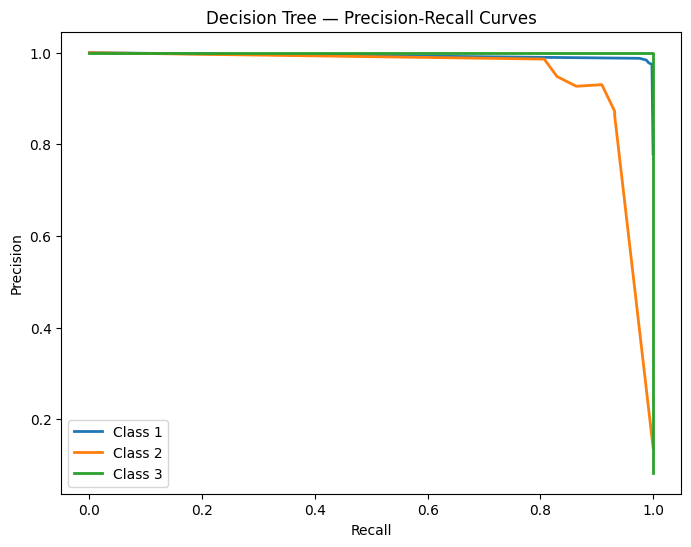

In [29]:
dt_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),   # not strictly needed for trees but kept for consistency
    ('dt', DecisionTreeClassifier(
        criterion='entropy',
        max_depth=7,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42
    ))
])
_ = evaluate_model('Decision Tree', dt_pipeline, X_train, y_train, X_test, y_test)

  ## **Multilayer Perceptron (MLP)** (Supervised Learning)

Multilayer Perceptron — Accuracy: 0.956, Balanced Accuracy: 0.893
Precision (macro): 0.905, Recall (macro): 0.893, F1 (macro): 0.899
Precision (weighted): 0.956, Recall (weighted): 0.956, F1 (weighted): 0.956

Classification Report for Multilayer Perceptron:
              precision    recall  f1-score   support

           1      0.980     0.986     0.983       497
           2      0.874     0.864     0.869        88
           3      0.863     0.830     0.846        53

    accuracy                          0.956       638
   macro avg      0.905     0.893     0.899       638
weighted avg      0.956     0.956     0.956       638



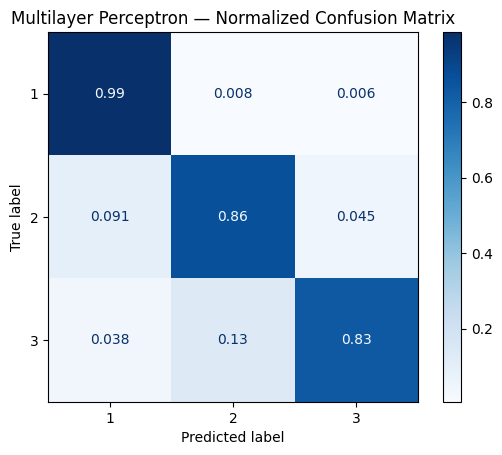

ROC AUC OVR (macro): 0.983
ROC AUC OVO (macro): 0.977


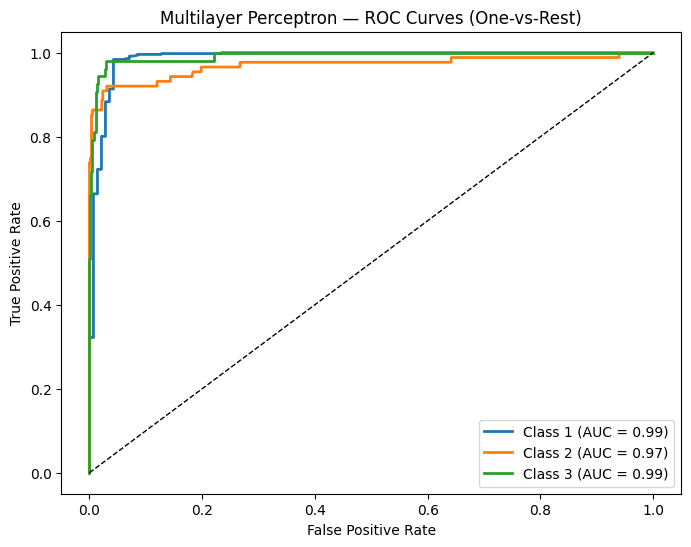

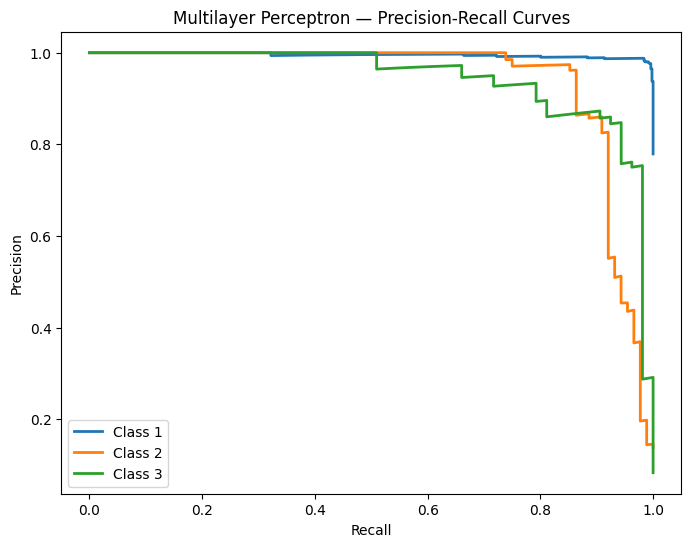

In [30]:
mlp_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=42
    ))
])
_ = evaluate_model('Multilayer Perceptron', mlp_pipeline, X_train, y_train, X_test, y_test)

  ## **Random Forest** (Supervised Learning)

Random Forest — Accuracy: 0.978, Balanced Accuracy: 0.939
Precision (macro): 0.980, Recall (macro): 0.939, F1 (macro): 0.959
Precision (weighted): 0.978, Recall (weighted): 0.978, F1 (weighted): 0.978

Classification Report for Random Forest:
              precision    recall  f1-score   support

           1      0.978     1.000     0.989       497
           2      0.963     0.875     0.917        88
           3      1.000     0.943     0.971        53

    accuracy                          0.978       638
   macro avg      0.980     0.939     0.959       638
weighted avg      0.978     0.978     0.978       638



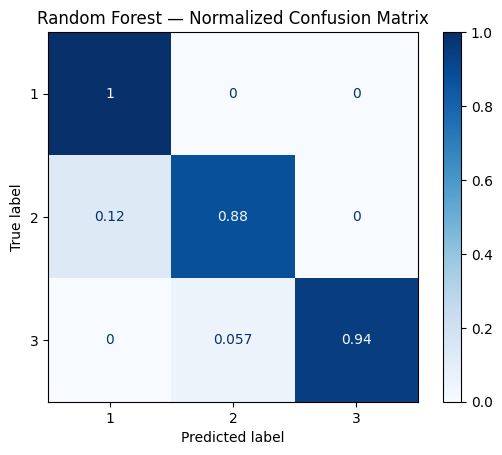

ROC AUC OVR (macro): 0.995
ROC AUC OVO (macro): 0.992


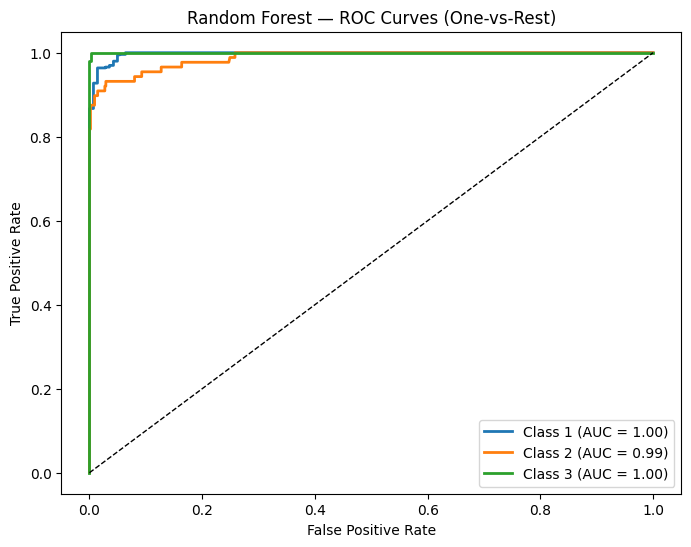

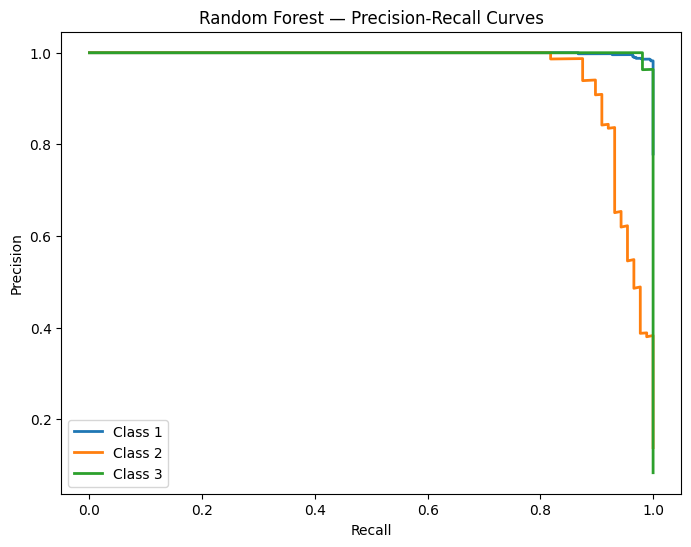

In [31]:
rf_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

_ = evaluate_model('Random Forest', rf_pipeline, X_train, y_train, X_test, y_test)

In [32]:
#Cross-validation

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, make_scorer
)
import numpy as np

scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'roc_auc_ovr': 'roc_auc_ovr'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    rf_pipeline, X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

for key in cv_results:
    if key.startswith('test_'):
        scores = cv_results[key]
        print(f"{key}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

test_accuracy: 0.982 ± 0.003
test_precision_macro: 0.979 ± 0.011
test_recall_macro: 0.956 ± 0.009
test_f1_macro: 0.967 ± 0.010
test_roc_auc_ovr: 0.997 ± 0.003


  ## **Gradient Boost** (Supervised Learning)

Gradient Boosting — Accuracy: 0.986, Balanced Accuracy: 0.969
Precision (macro): 0.991, Recall (macro): 0.969, F1 (macro): 0.979
Precision (weighted): 0.986, Recall (weighted): 0.986, F1 (weighted): 0.986

Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

           1      0.984     0.998     0.991       497
           2      0.988     0.909     0.947        88
           3      1.000     1.000     1.000        53

    accuracy                          0.986       638
   macro avg      0.991     0.969     0.979       638
weighted avg      0.986     0.986     0.986       638



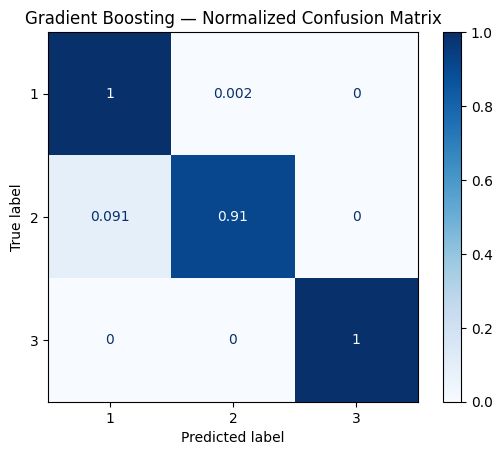

ROC AUC OVR (macro): 0.995
ROC AUC OVO (macro): 0.997


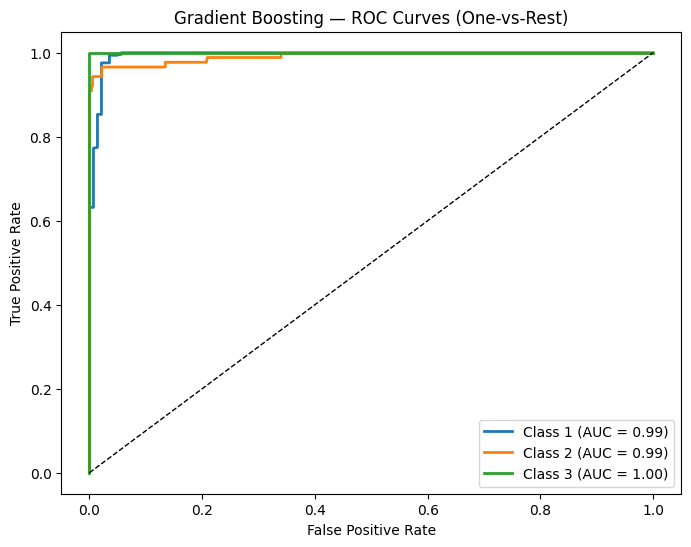

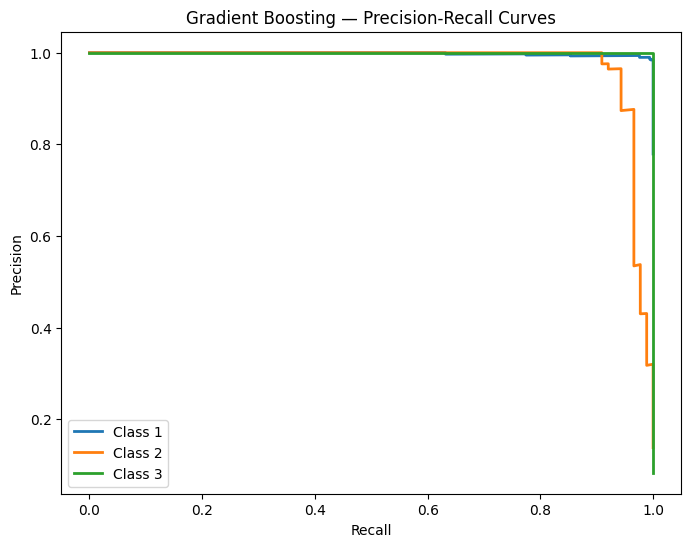

In [33]:
gb_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('gb', GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])
gb_fit_kwargs = {'gb__sample_weight': sample_weight_train}
_ = evaluate_model('Gradient Boosting', gb_pipeline, X_train, y_train, X_test, y_test, fit_kwargs=gb_fit_kwargs)

In [34]:
#Cross-validation

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)
import numpy as np

scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'roc_auc_ovr': 'roc_auc_ovr'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    gb_pipeline, X, y,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

for key in cv_results:
    if key.startswith('test_'):
        scores = cv_results[key]
        print(f"{key}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")


test_accuracy: 0.988 ± 0.005
test_precision_macro: 0.987 ± 0.009
test_recall_macro: 0.977 ± 0.009
test_f1_macro: 0.981 ± 0.008
test_roc_auc_ovr: 0.995 ± 0.006


## **Support Vector Machine (SVM)** (Supervised Learning)

Support Vector Machine — Accuracy: 0.964, Balanced Accuracy: 0.914
Precision (macro): 0.921, Recall (macro): 0.914, F1 (macro): 0.918
Precision (weighted): 0.964, Recall (weighted): 0.964, F1 (weighted): 0.964

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           1      0.986     0.988     0.987       497
           2      0.876     0.886     0.881        88
           3      0.902     0.868     0.885        53

    accuracy                          0.964       638
   macro avg      0.921     0.914     0.918       638
weighted avg      0.964     0.964     0.964       638



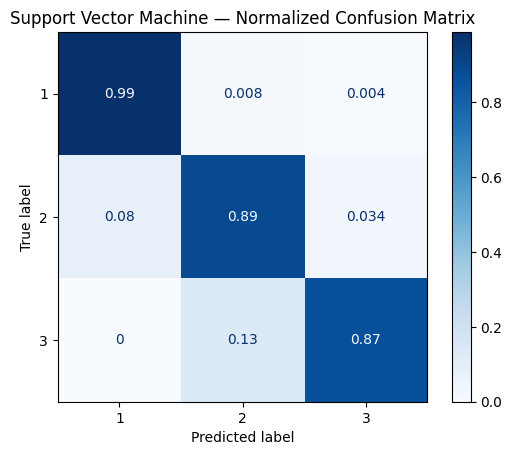

ROC AUC OVR (macro): 0.994
ROC AUC OVO (macro): 0.986


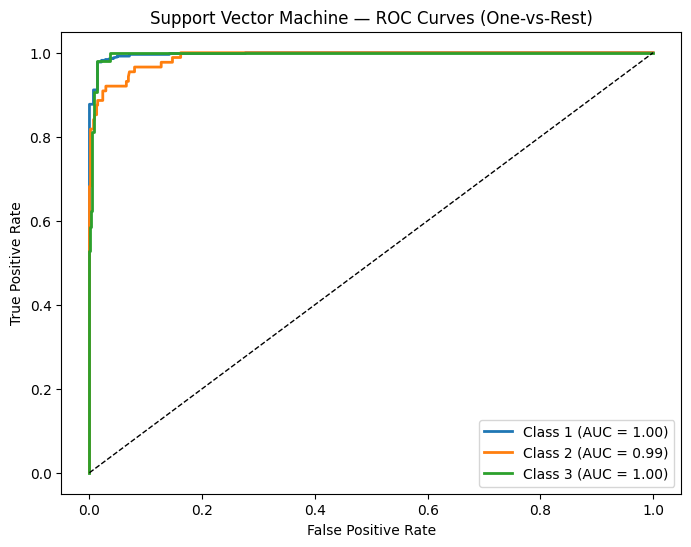

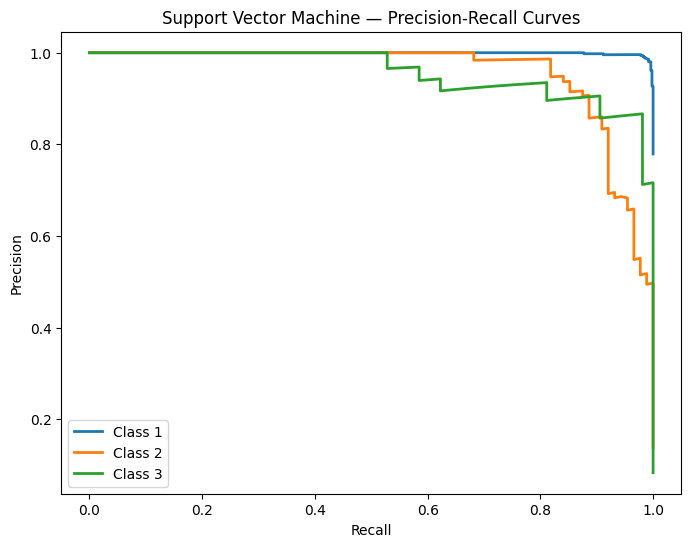

In [35]:
svm_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        C=2.0,
        gamma='scale',
        class_weight='balanced',
        probability = True
    ))
])
_ = evaluate_model('Support Vector Machine', svm_pipeline, X_train, y_train, X_test, y_test)

## Compiling the Models

In [36]:
# Aggregate model performance
results_df = pd.DataFrame(results).sort_values('Balanced Accuracy', ascending=False)
results_df = results_df.drop_duplicates()
results_df.reset_index(drop=True)

,Model,Accuracy,Balanced Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted
0,Gradient Boosting,0.985893,0.969026,0.990594,0.969026,0.979252,0.985932,0.985893,0.985651
1,Decision Tree,0.978056,0.965673,0.971400,0.965673,0.968495,0.977888,0.978056,0.977952
2,Random Forest,0.978056,0.939465,0.980282,0.939465,0.958865,0.977960,0.978056,0.977560
3,Support Vector Machine,0.963950,0.914072,0.921436,0.914072,0.917635,0.963858,0.963950,0.963872
4,Multilayer Perceptron,0.956113,0.893247,0.905436,0.893247,0.899225,0.955578,0.956113,0.955809
5,Logistic Regression,0.946708,0.881718,0.866606,0.881718,0.873223,0.949004,0.946708,0.947442
6,K-Nearest Neighbors,0.929467,0.791986,0.873822,0.791986,0.825897,0.926432,0.929467,0.925942


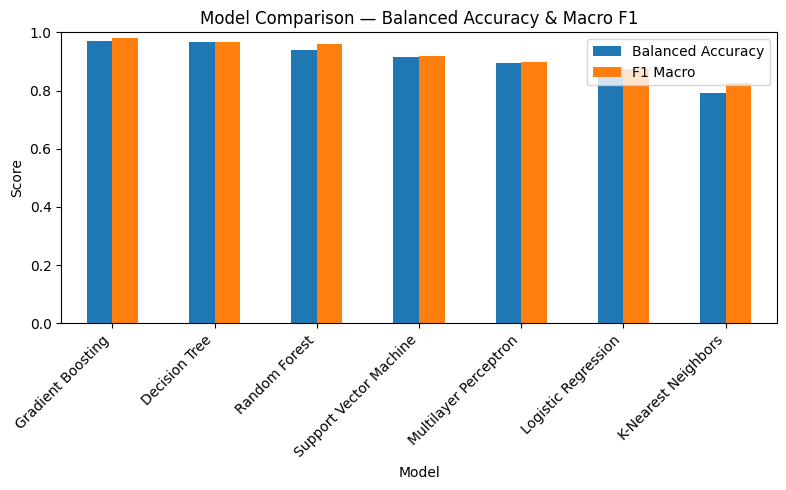

In [37]:
# Visual comparison
fig, ax = plt.subplots(figsize=(8, 5))
results_df.plot(x='Model', y=['Balanced Accuracy', 'F1 Macro'], kind='bar', ax=ax)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Model Comparison — Balanced Accuracy & Macro F1')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **Neural Network Model** (Supervised Learning)

Search space: 4 configurations


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val Accuracy: 0.9695 (stopped at epoch 31)
best model
Val Accuracy: 0.9624 (stopped at epoch 33)
Val Accuracy: 0.9671 (stopped at epoch 34)
Val Accuracy: 0.9671 (stopped at epoch 50)

Total time: 0m 38s

Best Validation Accuracy: 0.9695

Best Configuration:
   Layers: 3
   Initial units: 256
   Dropout rate: 0.180
   Learning rate: 0.008000
   L2 regularization: 0.0001
   Reduction strategy: linear

Test Accuracy: 0.9648
Precision: 0.9645
Recall: 0.9648
F1-Score: 0.9645

Classification Report:
              precision    recall  f1-score   support

           0     0.9791    0.9880    0.9835       332
           1     0.9273    0.8644    0.8947        59
           2     0.8889    0.9143    0.9014        35

    accuracy                         0.9648       426
   macro avg     0.9318    0.9222    0.9266       426
weighted avg     0.9645    0.9648    0.9645       426

ROC AUC Score: 0.9915


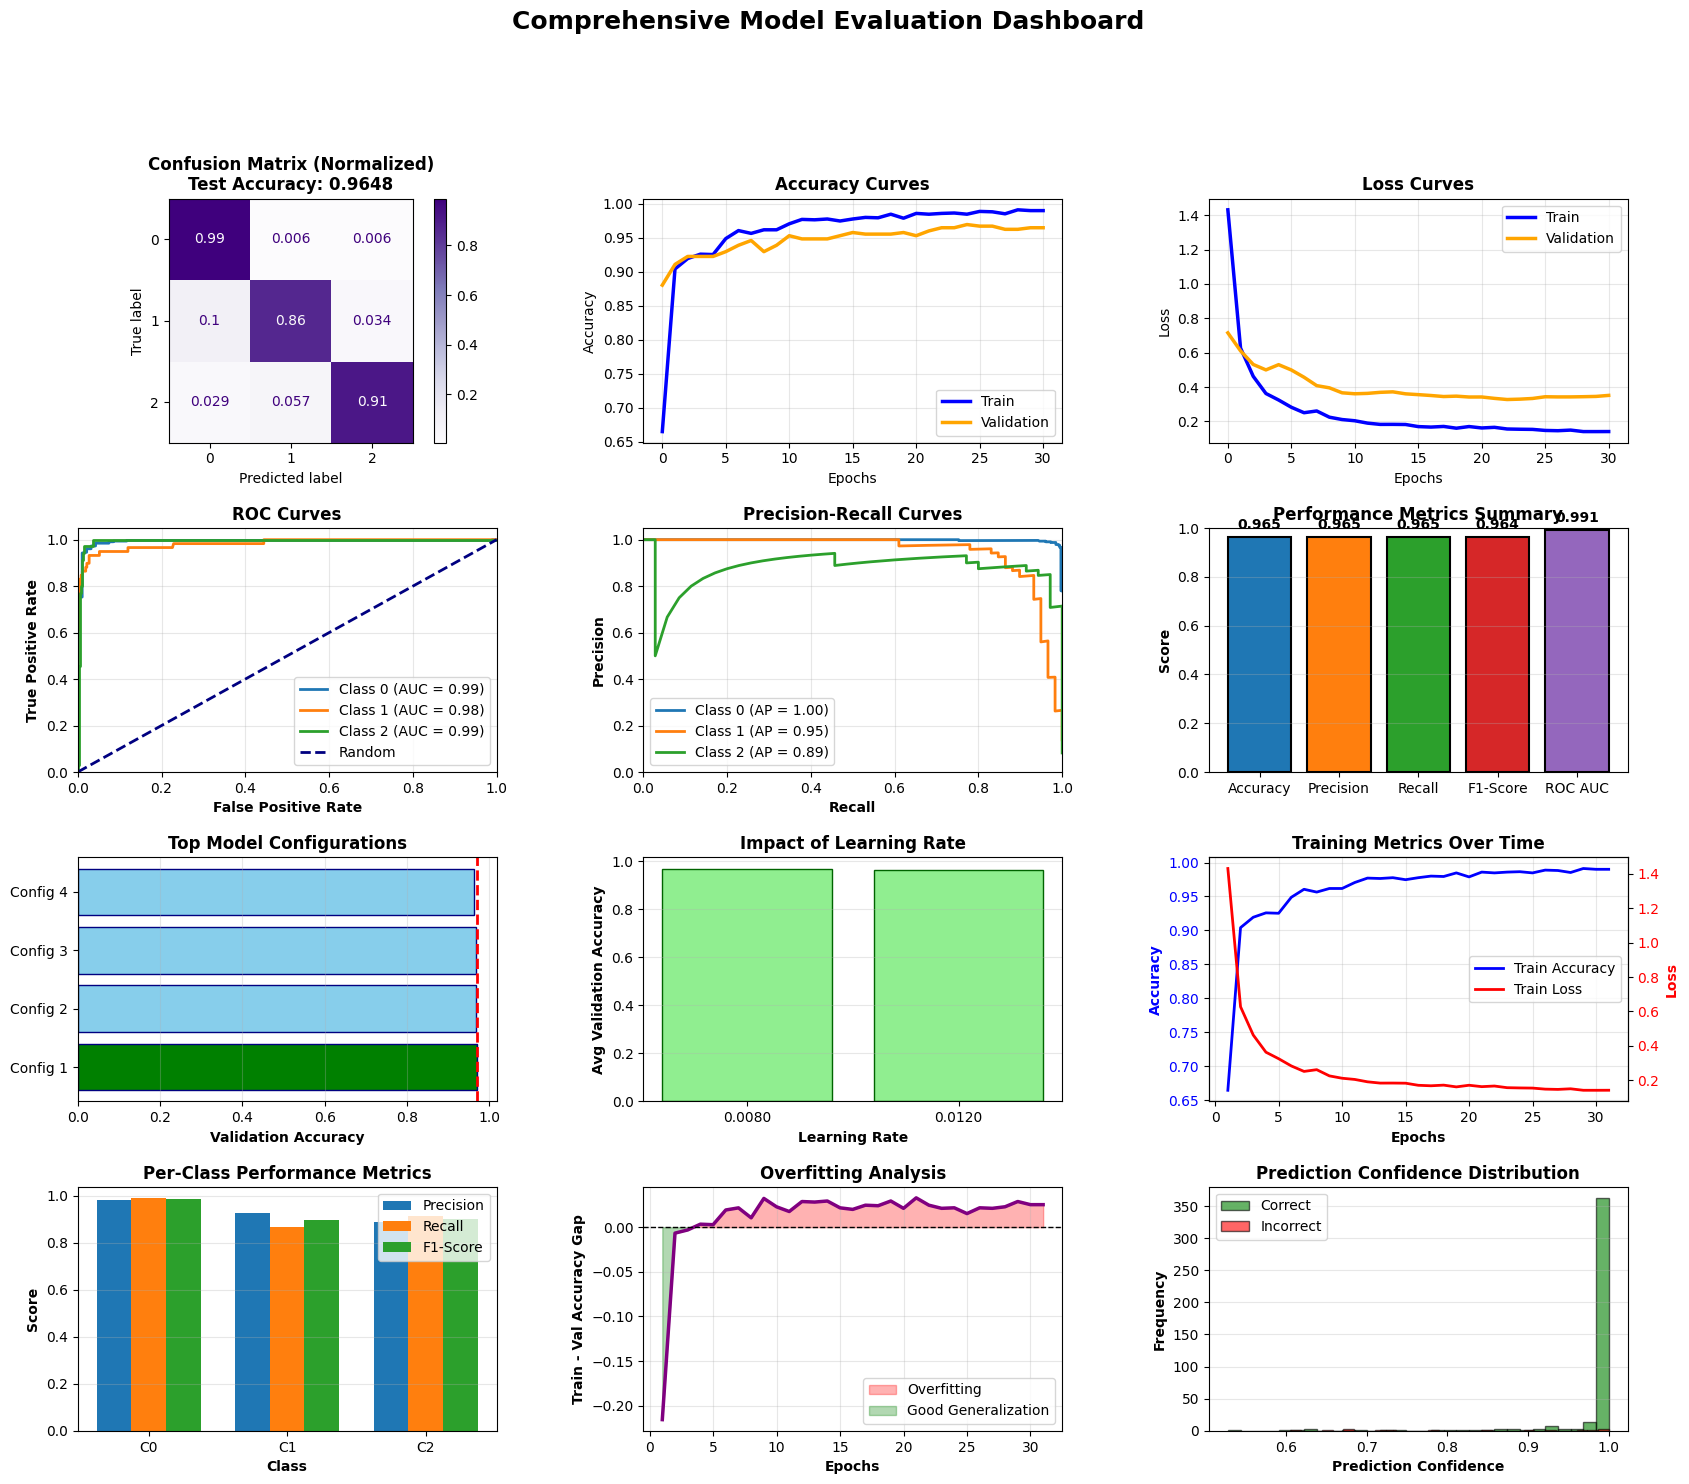


 Model weights saved as 'model_weights.weights.h5'
 Complete model saved as 'fine_tuned_elu_model.h5'


Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_505 (Dense)               │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_390 (Activation)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_390 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_506 (Dense)               │ (None, 192)            │        49,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_391 (Activation)     │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_391 (Dropout)           │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_507 (Dense)               │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_392 (Activation)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_392 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_508 (Dense)               │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,651 (971.30 KB)

 Trainable params: 82,883 (323.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 165,768 (647.54 KB)

In [44]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, ConfusionMatrixDisplay,
                            roc_curve, auc, precision_recall_curve, average_precision_score,
                            roc_auc_score, precision_score, recall_score, f1_score)
import time

np.random.seed(42)
tf.random.set_seed(42)

X = np.nan_to_num(X, nan=0.0)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

num_classes = len(np.unique(y_encoded))
input_shape = X_train_scaled.shape[1]

def build_elu_model(input_shape, num_classes, n_layers, initial_units,
                     dropout_rate, lr, l2_reg, reduction='linear'):
    model = Sequential()

    for i in range(n_layers):
        if reduction == 'linear':
            units = max(32, initial_units - (i * initial_units // (n_layers + 1)))
        elif reduction == 'exponential':
            units = max(32, initial_units // (2 ** i))
        else:
            units = max(32, initial_units // (i + 1))

        if i == 0:
            model.add(Dense(units,
                          input_shape=(input_shape,),
                          kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                          kernel_initializer='he_normal'))
        else:
            model.add(Dense(units,
                          kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                          kernel_initializer='he_normal'))

        model.add(Activation('elu'))
        current_dropout = dropout_rate * (1 - 0.15 * i / n_layers)
        model.add(Dropout(current_dropout))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

param_grid = {
    'n_layers': [3],
    'initial_units': [256],
    'dropout_rate': [0.18, 0.22],
    'lr': [0.008, 0.012],
    'l2_reg': [0.0001],
    'reduction': ['linear']
}

print(f"Search space: {len(param_grid['n_layers']) * len(param_grid['initial_units']) * len(param_grid['dropout_rate']) * len(param_grid['lr']) * len(param_grid['l2_reg']) * len(param_grid['reduction'])} configurations")

best_val_acc = 0
best_params = None
best_history = None
best_model = None
all_results = []

start_time = time.time()

for n_layers in param_grid['n_layers']:
    for initial_units in param_grid['initial_units']:
        for dropout_rate in param_grid['dropout_rate']:
            for lr in param_grid['lr']:
                for l2_reg in param_grid['l2_reg']:
                    for reduction in param_grid['reduction']:

                        config_str = (f"layers={n_layers}, units={initial_units}, "
                                    f"dropout={dropout_rate:.2f}, lr={lr:.4f}, "
                                    f"l2={l2_reg}, reduction={reduction}")

                        model = build_elu_model(
                            input_shape, num_classes, n_layers, initial_units,
                            dropout_rate, lr, l2_reg, reduction
                        )

                        early_stopping = EarlyStopping(
                            monitor='val_loss',
                            patience=8,
                            restore_best_weights=True,
                            verbose=0
                        )

                        reduce_lr = ReduceLROnPlateau(
                            monitor='val_loss',
                            factor=0.5,
                            patience=4,
                            min_lr=1e-6,
                            verbose=0
                        )

                        history = model.fit(
                            X_train_scaled, y_train,
                            validation_data=(X_test_scaled, y_test),
                            epochs=50,
                            batch_size=512,
                            callbacks=[early_stopping, reduce_lr],
                            verbose=0
                        )

                        val_acc = max(history.history['val_accuracy'])
                        epochs_trained = len(history.history['val_accuracy'])

                        all_results.append({
                            'config': config_str,
                            'val_acc': val_acc,
                            'epochs': epochs_trained,
                            'params': (n_layers, initial_units, dropout_rate, lr, l2_reg, reduction)
                        })

                        print(f"Val Accuracy: {val_acc:.4f} (stopped at epoch {epochs_trained})")

                        if val_acc > best_val_acc:
                            best_val_acc = val_acc
                            best_params = (n_layers, initial_units, dropout_rate, lr, l2_reg, reduction)
                            best_history = history
                            best_model = model
                            print(f"best model")
elapsed_time = time.time() - start_time

print("\n" + "="*70)
print("="*70)
print(f"Total time: {elapsed_time//60:.0f}m {elapsed_time%60:.0f}s")
print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
print(f"\nBest Configuration:")
print(f"   Layers: {best_params[0]}")
print(f"   Initial units: {best_params[1]}")
print(f"   Dropout rate: {best_params[2]:.3f}")
print(f"   Learning rate: {best_params[3]:.6f}")
print(f"   L2 regularization: {best_params[4]}")
print(f"   Reduction strategy: {best_params[5]}")

# Predictions and metrics
y_pred_proba = best_model.predict(X_test_scaled, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

test_acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred, digits=4)}")

# Calculate ROC AUC
if num_classes == 2:
    roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
else:
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
print(f"ROC AUC Score: {roc_auc:.4f}")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.35)

# 1. Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, normalize='true', cmap='Purples', ax=ax1
)
ax1.set_title(f"Confusion Matrix (Normalized)\nTest Accuracy: {test_acc:.4f}", fontweight='bold')

# 2. Training & Validation Accuracy
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(best_history.history['accuracy'], label='Train', linewidth=2.5, color='blue')
ax2.plot(best_history.history['val_accuracy'], label='Validation', linewidth=2.5, color='orange')
ax2.set_title('Accuracy Curves', fontweight='bold')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# 3. Training & Validation Loss
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(best_history.history['loss'], label='Train', linewidth=2.5, color='blue')
ax3.plot(best_history.history['val_loss'], label='Validation', linewidth=2.5, color='orange')
ax3.set_title('Loss Curves', fontweight='bold')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# 4. ROC Curves (per class)
ax4 = fig.add_subplot(gs[1, 0])
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc_val = auc(fpr, tpr)
    ax4.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.2f})')
else:
    for i in range(min(num_classes, 5)):  # Plot first 5 classes
        fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
        roc_auc_val = auc(fpr, tpr)
        ax4.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc_val:.2f})')
ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate', fontweight='bold')
ax4.set_ylabel('True Positive Rate', fontweight='bold')
ax4.set_title('ROC Curves', fontweight='bold')
ax4.legend(loc="lower right")
ax4.grid(True, alpha=0.3)

# 5. Precision-Recall Curves
ax5 = fig.add_subplot(gs[1, 1])
if num_classes == 2:
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
    avg_prec = average_precision_score(y_test, y_pred_proba[:, 1])
    ax5.plot(recall_vals, precision_vals, color='darkorange', lw=2,
             label=f'PR curve (AP = {avg_prec:.2f})')
else:
    for i in range(min(num_classes, 5)):
        precision_vals, recall_vals, _ = precision_recall_curve(
            (y_test == i).astype(int), y_pred_proba[:, i]
        )
        avg_prec = average_precision_score((y_test == i).astype(int), y_pred_proba[:, i])
        ax5.plot(recall_vals, precision_vals, lw=2, label=f'Class {i} (AP = {avg_prec:.2f})')
ax5.set_xlim([0.0, 1.0])
ax5.set_ylim([0.0, 1.05])
ax5.set_xlabel('Recall', fontweight='bold')
ax5.set_ylabel('Precision', fontweight='bold')
ax5.set_title('Precision-Recall Curves', fontweight='bold')
ax5.legend(loc="lower left")
ax5.grid(True, alpha=0.3)

# 6. Metrics Bar Chart
ax6 = fig.add_subplot(gs[1, 2])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
metrics_values = [test_acc, precision, recall, f1, roc_auc]
colors_metrics = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = ax6.bar(metrics_names, metrics_values, color=colors_metrics, edgecolor='black', linewidth=1.5)
ax6.set_ylabel('Score', fontweight='bold')
ax6.set_title('Performance Metrics Summary', fontweight='bold')
ax6.set_ylim([0, 1.0])
ax6.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, metrics_values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# 7. Top Configurations
ax7 = fig.add_subplot(gs[2, 0])
sorted_results = sorted(all_results, key=lambda x: x['val_acc'], reverse=True)[:min(10, len(all_results))]
configs_short = [f"Config {i+1}" for i in range(len(sorted_results))]
accs = [r['val_acc'] for r in sorted_results]
colors = ['green' if i == 0 else 'skyblue' for i in range(len(sorted_results))]
ax7.barh(configs_short, accs, color=colors, edgecolor='navy')
ax7.set_xlabel('Validation Accuracy', fontweight='bold')
ax7.set_title('Top Model Configurations', fontweight='bold')
ax7.axvline(x=best_val_acc, color='red', linestyle='--', linewidth=2)
ax7.grid(axis='x', alpha=0.3)

# 8. Learning Rate Impact
ax8 = fig.add_subplot(gs[2, 1])
lr_impact = {}
for r in all_results:
    lr = r['params'][3]
    if lr not in lr_impact:
        lr_impact[lr] = []
    lr_impact[lr].append(r['val_acc'])
lr_avg = {k: np.mean(v) for k, v in lr_impact.items()}
ax8.bar([f"{k:.4f}" for k in lr_avg.keys()], lr_avg.values(),
        color='lightgreen', edgecolor='darkgreen')
ax8.set_xlabel('Learning Rate', fontweight='bold')
ax8.set_ylabel('Avg Validation Accuracy', fontweight='bold')
ax8.set_title('Impact of Learning Rate', fontweight='bold')
ax8.grid(axis='y', alpha=0.3)

# 9. Training Progress Metrics
ax9 = fig.add_subplot(gs[2, 2])
epochs_range = range(1, len(best_history.history['accuracy']) + 1)
ax9_twin = ax9.twinx()
line1 = ax9.plot(epochs_range, best_history.history['accuracy'], 'b-', linewidth=2, label='Train Accuracy')
line2 = ax9_twin.plot(epochs_range, best_history.history['loss'], 'r-', linewidth=2, label='Train Loss')
ax9.set_xlabel('Epochs', fontweight='bold')
ax9.set_ylabel('Accuracy', color='b', fontweight='bold')
ax9_twin.set_ylabel('Loss', color='r', fontweight='bold')
ax9.tick_params(axis='y', labelcolor='b')
ax9_twin.tick_params(axis='y', labelcolor='r')
ax9.set_title('Training Metrics Over Time', fontweight='bold')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax9.legend(lines, labels, loc='center right')
ax9.grid(True, alpha=0.3)

# 10. Per-Class Performance
ax10 = fig.add_subplot(gs[3, 0])
per_class_precision = precision_score(y_test, y_pred, average=None)
per_class_recall = recall_score(y_test, y_pred, average=None)
per_class_f1 = f1_score(y_test, y_pred, average=None)
x_pos = np.arange(min(len(per_class_precision), 8))  # Show first 8 classes
width = 0.25
ax10.bar(x_pos - width, per_class_precision[:len(x_pos)], width, label='Precision', color='#1f77b4')
ax10.bar(x_pos, per_class_recall[:len(x_pos)], width, label='Recall', color='#ff7f0e')
ax10.bar(x_pos + width, per_class_f1[:len(x_pos)], width, label='F1-Score', color='#2ca02c')
ax10.set_xlabel('Class', fontweight='bold')
ax10.set_ylabel('Score', fontweight='bold')
ax10.set_title('Per-Class Performance Metrics', fontweight='bold')
ax10.set_xticks(x_pos)
ax10.set_xticklabels([f'C{i}' for i in x_pos])
ax10.legend()
ax10.grid(axis='y', alpha=0.3)

# 11. Overfitting Analysis
ax11 = fig.add_subplot(gs[3, 1])
train_val_gap = np.array(best_history.history['accuracy']) - np.array(best_history.history['val_accuracy'])
ax11.plot(epochs_range, train_val_gap, linewidth=2.5, color='purple')
ax11.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax11.fill_between(epochs_range, train_val_gap, 0, where=(train_val_gap > 0),
                  alpha=0.3, color='red', label='Overfitting')
ax11.fill_between(epochs_range, train_val_gap, 0, where=(train_val_gap <= 0),
                  alpha=0.3, color='green', label='Good Generalization')
ax11.set_xlabel('Epochs', fontweight='bold')
ax11.set_ylabel('Train - Val Accuracy Gap', fontweight='bold')
ax11.set_title('Overfitting Analysis', fontweight='bold')
ax11.legend()
ax11.grid(True, alpha=0.3)

# 12. Prediction Confidence Distribution
ax12 = fig.add_subplot(gs[3, 2])
max_probs = np.max(y_pred_proba, axis=1)
correct_mask = (y_pred == y_test)
ax12.hist(max_probs[correct_mask], bins=30, alpha=0.6, label='Correct', color='green', edgecolor='black')
ax12.hist(max_probs[~correct_mask], bins=30, alpha=0.6, label='Incorrect', color='red', edgecolor='black')
ax12.set_xlabel('Prediction Confidence', fontweight='bold')
ax12.set_ylabel('Frequency', fontweight='bold')
ax12.set_title('Prediction Confidence Distribution', fontweight='bold')
ax12.legend()
ax12.grid(axis='y', alpha=0.3)

plt.suptitle('Comprehensive Model Evaluation Dashboard',
             fontsize=18, fontweight='bold', y=0.998)
plt.show()

# Save model weights to separate file
best_model.save_weights('model_weights.weights.h5')
print("\n Model weights saved as 'model_weights.weights.h5'")

# Save complete model
best_model.save('fine_tuned_elu_model.h5')
print(" Complete model saved as 'fine_tuned_elu_model.h5'")

best_model.summary()

# Save detailed results
with open('fine_tuning_results.txt', 'w') as f:
    f.write(f"Total time: {elapsed_time//60:.0f}m {elapsed_time%60:.0f}s\n")
    f.write(f"Configurations tested: {len(all_results)}\n\n")
    f.write(f"Best Validation Accuracy: {best_val_acc:.4f}\n")
    f.write(f"Test Accuracy: {test_acc:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n")
    f.write(f"ROC AUC: {roc_auc:.4f}\n\n")
    f.write("Best Configuration:\n")
    for param, value in zip(['Layers', 'Initial units', 'Dropout rate', 'Learning rate', 'L2 regularization', 'Reduction strategy'], best_params):
        if isinstance(value, float):
            f.write(f"{param}: {value:.6f}\n")
        else:
            f.write(f"{param}: {value}\n")

    f.write(f"\nTop {len(sorted_results)} Configurations:\n")
    for i, result in enumerate(sorted_results, 1):
        f.write(f"\n{i}. Val Acc: {result['val_acc']:.4f}\n")
        f.write(f"   {result['config']}\n")

    f.write("\n" + "="*70 + "\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, digits=4))